# Machine Learning for Genomics Assignment 3

`Carlos Angel`

`UNI : jcc2340`

# Identify yourself

Please write your name and uni. Additionally, modify the name of the notebook to include your first and last name.


In [1]:
uni = "jcc2340"
name = "Juan_Carlos_Angel"

# Hidden Markov Models

First we'll set up some helper functions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(2)

def norm(x):
    '''
    Return the input normalized to have sum of 1.
    '''
    return(x/x.sum())

def row_norm(x):
    '''
    Return the input normalized so that each row sums to 1.
    '''
    return x / x.sum(1, keepdims=True)

## Sampling from the HMM

An HMM is a `generative process` which means that given parameters T, E and gamma0 we can sample imaginary data from the model. Here's a function to just that, generating a sequence y of length S (as well as the underlying hidden states x).

In [3]:
def sampleHMM(gamma0, T, E, S):
    '''
Sample from the HMM

Parameters
----------
gamma0
    initial distribution over states of the HMM
T
    transition matrix of size K x K
E
    emission matrix size K x L
S
    sequence length

Returns
-------
x
    Vector of hidden states
y
    Vector of observations
    '''
    K = gamma0.size
    L = E.shape[1]
    x = np.zeros(S, dtype = np.int32)
    y = np.zeros(S, dtype = np.int32)
    x[0] = np.random.choice(K, p=gamma0)
    y[0] = np.random.choice(L, p=E[x[0], :])
    for t in range(1,S):
        x[t] = np.random.choice(K, p = T[x[t-1], :])
        y[t] = np.random.choice(L, p = E[x[t], :])
    return (x,y)

Let's make a toy 2-state HMM and sample from it.

Text(0.5, 1.0, 'Observations y')

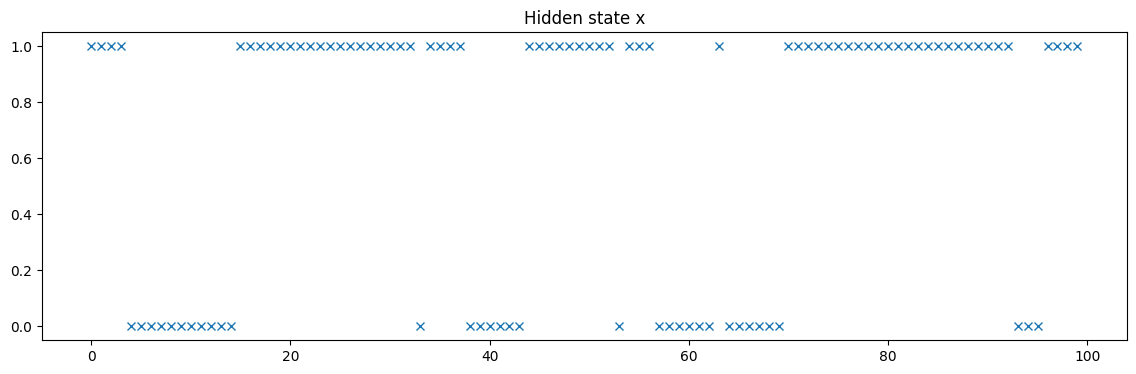

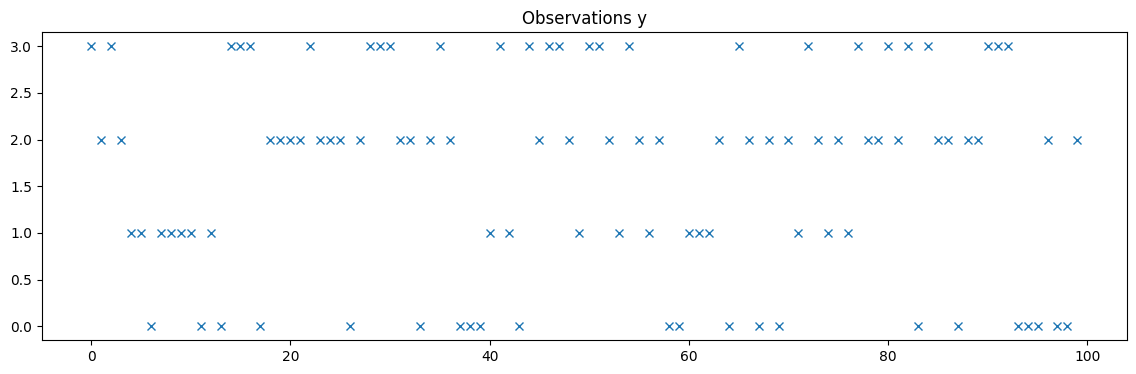

In [4]:
#The initial distribution over states.
gamma0_true = np.array([0., 1.]) # start in state 1 (rather than 0)
#The transition matrix of size K x K. T[i, j] is the probability of transitioning from state i to state j
T_true = np.array([[0.8, 0.2], [0.1, 0.9]]) # usually stay in the same state, a "sticky" HMM
#The emission matrix of size K x L. E[i, j] is the probability of emitting observation j when in state i.
E_true = np.array([[0.4, 0.4, 0.1, 0.1], [0.1, 0.1, 0.4, 0.4]])

np.random.seed(3)
x,y = sampleHMM(gamma0_true, T_true, E_true, S = 100)

plt.figure(figsize=(14,4))
plt.plot(x, "x")
plt.title("Hidden state x")

# the term "observation" refers to the visible outputs or data points that are directly observable in the system being modeled. These observations are contrasted with the "hidden states" which are not directly observable.
plt.figure(figsize=(14,4))
plt.plot(y, "x")
plt.title("Observations y")

Notice that the the Markov chain of hidden states tends to stay in the same state for a while, and that in state 1 we get more 2s and 3s in y.

## Forwards-backwards

$$ i : state $$
$$ t : time $$
$$ E : emission $$
$$ T : transition $$

Now let's see what the forward pass might look like.


First you'll be implementing the forward pass. We first initialize

Initialization
$$ f_{1:} = \text{norm}( \gamma_0 \cdot E_{:y_{1}} ) $$
where $f = \text{norm}(f_*)$ implies (normalization)
$$ f_i = \frac{ f^*_i }{ \sum_{i'} f^*_{i'} } $$

Per time point updates

Then at each time point $t$

Update for `r`


Calculate the raw forward probability for state i at time t by summing over all possible previous states j, weighted by the transition probability from state j to state i and the forward probability of being in state j at the previous time point.
$$ r_{ti} = \sum_j T_{ji} f_{(t-1)j} $$

`r_ti` :  The accumulated probability of reaching state i at time  t, considering all possible previous states.

`E_iy_t` : The emission probability of observing the current observation y_t given the current state i.

This multiplies the raw forward probability by the probability of emitting the observation y_t in state i.
$$ f^*_{ti} = r_{ti} E_{iy_t} $$

This normalizes the forward probabilities at time t so that they sum to 1.

$$ f_{ti} = \frac{ f^*_{ti} }{ \sum_{i'} f^*_{ti'} } $$

### Task 1. [1 point]

Write the per time point updates above for $r$ and $f$ in matrix notation (this is what you'll want to use in the code). Consider $r$ and $f$ as matrices, use $\cdot$ to denote elementwise multiplication and make use of the `norm` function defined above.

TODO: replace the ?

We want to calculate the new probability for each state as a sum of the probabilities of being in each previous state multiplied by the probability of transitioning from that state to the current state. This requires summing across the rows (previous states) of T for each column (current state).
By trasposing T, the rows become the columns and vice versa. Now my column i-th of transposed T represents the transition porbabilities into state i from other state.
$$ r_{t:} = T^{T} f_{(t-1)} $$
$$ f^* = r_{t:} E_{:y_t} $$

This ensures that the sum of the forward probabilities across all states at time t equals 1.
$$ f_{t:} = norm(f^*)$$

### Task [2 points]

Here's a template for you to fill in. Bear in mind for the time indexing Python uses 0-indexing though whereas in mathematical equations we  always use 1-indexing.   

In [5]:
def forwards(y, gamma0, T, E):
    '''
Forward pass of forwards-backwards algorithm.

Parameters
----------
y
    vector of observations, assumed to be in range(E.shape[1])
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
E
    emission matrix size K x L
Returns
-------
f
    forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
  '''
    S = y.size
    K = T.shape[0]
    # TODO initialize f
    f = np.zeros((S,K))
    # size sequence x number of states

    # TODO: calculate f[0,:] #first
    f[0,:] = norm(E[:,y[0]] * gamma0)
    # initializing the first row of f with the initial distribution over states gamma0 and the emission probability of the first observation y[0]

    # TODO: loop forwared to calculate f[1:,:]
    # Basically we want to do this for every time step t in the sequence
    # by obtaining the emission probability of the observation y[t] by the probability of transitioning from the previous state to the current state f[t-1] * T (transition matrix)
    for t in range(1,S):
        r_t = f[t-1] @ T
        f[t,:] = norm(E[:,y[t]]* r_t)
        #computes the matrix-vector product of the transition matrix
        '''T and the forward probabilities from the previous time step for all states simultaneously. The result is then element-wise multiplied by the observation likelihood vector for the current observation.'''
    return f

Your next task is implementing the equivalent backwards pass. The updates in matrix notation, for $t=\{S-1,\cdots,1\}$ are:
$$ q_{t:} = (E_{:y_{t+1}})' \cdot b_{t+1:} $$

$$ b_{t:} = (T q'_{t:})' $$

(by convention no `norm` is used).
Note $b_{S:} = [1, ..., 1]$, $\cdot$ implies elementwise multiplication and $q'$ denotes the transpose.

### Task [1 point]

Write the updates in NON matrix notation (as I have for the forward pass above):

( intermediate calculation at each time t for each state i)

Element-wise product of the emission probability for the next observation $y_{t+1}$ and the backward probability $b_{(t+1)i}$


$$ q_{ti} = E_iy_{t+1} \cdot b_{(t+1)i} $$

Backward probability $ b_{ti} $ at time ${t}$ and state $i$ for all j

$$ b_{ti} = \sum_j T_{ij} q_{tj} $$



### Task [1 point]

Here's a template for you to fill in. Bear in mind for the time indexing Python uses 0-indexing though whereas in mathematical equations we  always use 1-indexing.   

In [6]:
def backwards(y, T, E):
    '''
Backwards pass of forwards-backwards algorithm.

Parameters
----------
y
    vector of observations, assumed to be in range(E.shape[1])
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
E
    emission matrix size K x L

Returns
-------
b
    Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S
  '''
    S = y.size
    K = T.shape[0]
    # TODO: initialize b
    b = np.zeros((S,K)) #S x K array filled with zeros
    b[S-1, :] = np.array([1] * K) # last row of b is all ones because there are no more observations after the last one, supposing that the sequence is complete summed to 1

    # TODO: loop backwards from S-2 to 0
    for t in range(S-2,-1,-1):
        q = E[:,y[t+1]] * b[t+1,:] # intermediate vector q is the emission probability of the observation y[t+1] multiplied by the backward probability at time t+1 for each state
        b[t,:] = T @ q # updates the backward probabilities at time t for each state. It calculates the dot product of the transition matrix T and the intermediate vector q
    return b

Armed with the forwards and backwards functions we can now get the posterior over X given the observations we just generated, Y. Here we're cheating: since we generated the data we know what the true parameters gamma0, T and E are so we'll use those in forwards-backwards.

In [7]:
def forwards_backwards( y, gamma0, T, E ):
    f = forwards(y, gamma0, T, E) # result is S x K
    b = backwards(y, T, E)
    gamma = row_norm( f * b ) # get the posterior gamma[t,k] = P(X[t]=k | y[0:S])
    return gamma, f, b

gamma, f, b = forwards_backwards( y, gamma0_true, T_true, E_true )
assert( abs(gamma[-1,1] - 0.6397375803142555) < 1e-10  )
assert( abs(gamma[-50,1] - 0.9566209571811642) < 1e-10  )

 Make sure the assertions pass! If not check your backwards code! (and make sure you didn't change the random seed)

 We can then look how well our posterior over X agrees with the true X, since we also have that from the simulation.

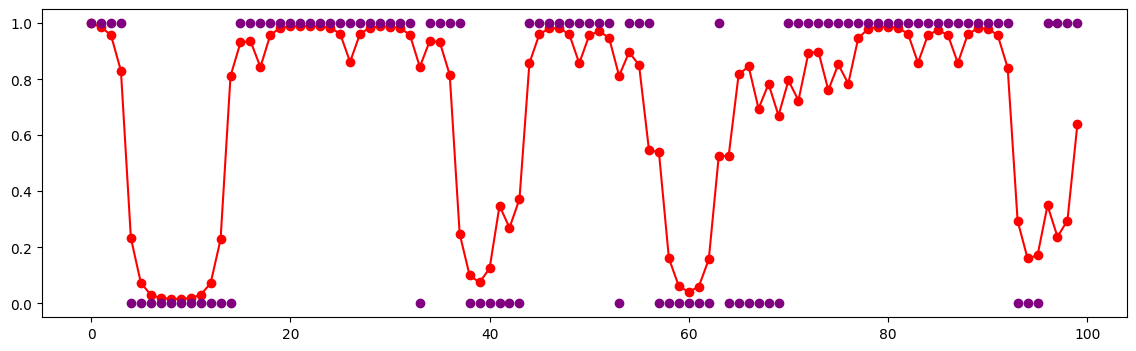

In [8]:
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o",color="red") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o",color='purple') # true hidden state

You can see that the posterior tends towards the `correct` hidden state, and in fact gets it right 86% of the time:

In [9]:
np.mean((gamma[:,1] > .5) == (x==1))

0.86

There is some uncertainty because either state can generate any four of the observation values, just with somewhat different probabilities.

## Baum-Welch
" Baum-Welch algorithm is an Expectation-Maximization (EM) algorithm used for training Hidden Markov Models (HMMs) "

Below we provide an implementation of Baum-Welch with the E-step (forwards backwards) and the M-step implemented for T but not for E.

### Task [2 points]

Implement the M-step for the emission matrix E. From class:
(M-step / maximization step for expectation maximization algorithms)


This represents the intermediate step in calculating updated emission probabilities. It sums over all time steps (t), accumulating the probability $ \gamma_{ti} $ (prob of being in state i at time t), whenever the observed symbol at time t is equals to j

$$ E^*_{ij} = \sum_{t=1}^S \gamma_{ti} 1[ y_t = j ] $$

Normalizing these counts so that the emission probabilities for each state sum to 1.
$$ E_{i:} = \text{norm}(E^*_{i:}) $$

[1 point]:
Implement the $E$ update without looping over $t$. Hint: making the S x L matrix Y with elements $Y_{tj} = 1[ y_t = j ]$ will be useful.

In [10]:
def baum_welch(y, gamma0, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    y
        vector of observations
    gamma0
        initial distribution of the hidden chain
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j] = P(Y[t]=j | X[t]=i)
  '''
    K = gamma0.size
    L = 1+max(y) # number of symbols
    S = y.size # length of sequence y (number of time steps)

    Y = np.zeros([S, L]) # S x L array filled with zeros

    Y[range(S), np.int_(y)] = 1 # for each time step t in the sequence, the observation y[t] is set to 1 in the corresponding row of Y

    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) )
    E = row_norm( np.random.rand(K, L).astype(np.float32) )

    it = 0
    oldT = T
    oldE = E + tol +1

    while (np.abs(oldT-T).sum() + np.abs(oldE-E).sum() > tol) and (it<maxIt):
        it += 1

        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b = forwards_backwards(y, gamma0, T, E)

        # M-step
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], E[:,y[t+1]] * b[t+1,:] ) )
        T = row_norm(Tstar)

        # TODO: E update
        Estar = np.dot(gamma.T, Y)

        E = row_norm(Estar)

    return (T, E)

In [11]:
np.random.seed(2)

T_mle, E_mle = baum_welch(y, gamma0_true)

print("True T:\n", T_true)
print("Infered T:\n", T_mle)
print("Mean absolute error in T: %.3f" % np.mean(np.abs(T_true - T_mle)))

print("True E:\n", E_true)
print("Infered E:\n", E_mle )
print("Mean absolute error in E: %.3f" % np.mean(np.abs(E_true - E_mle)))

assert( abs(E_mle[0,0] - 0.19228533549712362) < 1e-10 )

True T:
 [[0.8 0.2]
 [0.1 0.9]]
Infered T:
 [[0.91 0.09]
 [0.08 0.92]]
Mean absolute error in T: 0.066
True E:
 [[0.4 0.4 0.1 0.1]
 [0.1 0.1 0.4 0.4]]
Infered E:
 [[1.92e-01 3.87e-01 2.20e-01 2.01e-01]
 [2.44e-01 4.46e-13 4.44e-01 3.11e-01]]
Mean absolute error in E: 0.102


Make sure the assertion passes! If not check your update for E.

These estimates are clearly better than random, but there is some overfitting going on: note in particular the almost 0 probability of generating the 2nd observed value from state 1, which we know should be 0.1. Try a few other random seeds (this will change the random initialization of E and T) to see that most are worse than the one I picked!

In practice for EM (as well as other optimization approaches that get stuck in local optima) we would do multiple random restarts (e.g. 10 - 50 typically) and somehow score which are best. While we won't cover it here, for HMMs it is possible to calculate the marginal likelihood $P(Y|E,T)$ as part of the forward-backwards algorithm, which can then be used as such as score.

Let's see how well we did at recovering x:

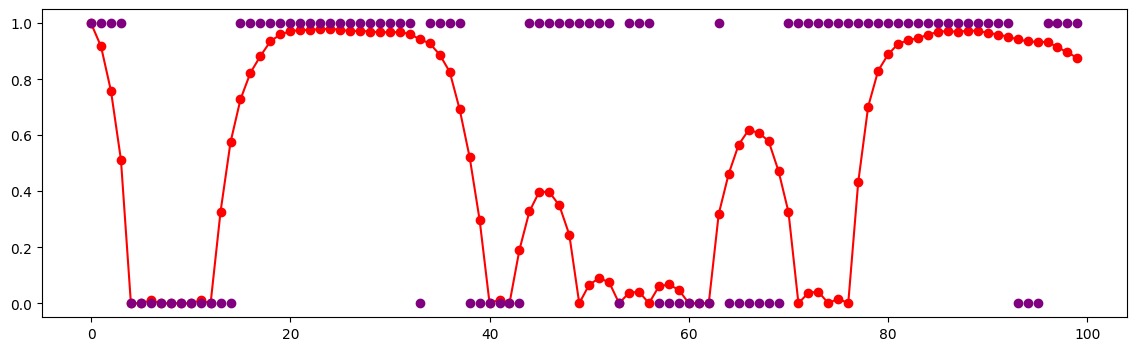

In [12]:
gamma, f, b = forwards_backwards(y, gamma0_true, T_mle, E_mle)
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o",color='red') # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o",color='purple') # true hidden state

The recovered x is "better than random", in that considering this as a classifier, we're getting the right state 69% of the time:

In [13]:
np.mean((gamma[:,1] > .5) == (x==1))

0.69

However there are many regions where the wrong state is inferred because of the errors in the recovered E matrix.

One easy solution to this overfitting is to add a pseudocount of 1 to all the values in Estar and Tstar. You can interpret this as putting a Dirichlet(2,...,2) prior on each row of E and T, or using a Dirichlet(1,...,1) prior on those rows but updating to the posterior expectation rather than the maximum likelihood estimate (a bit more like variational Bayes).

### Task [1 point]

Copy your code for `baum_welch` but add 1 to Estar and Tstar just before normalizing with row_norm.

In [14]:
def baum_welch_with_pseudocount(y, gamma0, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    y
        vector of observations
    gamma0
        initial distribution of the hidden chain
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j] = P(Y[t]=j | X[t]=i)
  '''
    K = gamma0.size #Number of states in the HMM. Determined by the size of gamma0.
    L = 1+max(y) # Number of distinct observation symbols. Determined by the size of y.
    S = y.size # Length of the sequence y. Determined by the size of y.
    Y = np.zeros([S, L])  #An S x L matrix used in updating the emission matrix. Each row corresponds to a time step and has a 1 in the column corresponding to the observed symbol at that time.
    Y[range(S), np.int_(y)] = 1

    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) )
    E = row_norm( np.random.rand(K, L).astype(np.float32) )

    it = 0
    oldT = T
    oldE = E + tol +1

    while (np.abs(oldT-T).sum() + np.abs(oldE-E).sum() > tol) and (it<maxIt):
        it += 1

        oldT = T.copy()
        oldE = E.copy()

        # E-step / Expectation step / Forward-Backward algorithm
        gamma, f, b = forwards_backwards(y, gamma0, T, E)

        # M-step / Maximization step
        Tstar = np.zeros((K,K))

        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], E[:,y[t+1]] * b[t+1,:] ) )
        T = row_norm(Tstar + 1)

        # TODO: E update with pseudocount
        Estar = np.dot(gamma.T, Y)

        E = row_norm(Estar + 1)

    return (T, E)

In [15]:
np.random.seed(2)

T_mle, E_mle = baum_welch_with_pseudocount(y, gamma0_true)

assert( abs(E_mle[0,0] - 0.298322068734388) < 1e-10 )

print("True T:\n", T_true)
print("Infered T:\n", T_mle)
print("Mean absolute error in T: %.3f" % np.mean(np.abs(T_true - T_mle)))

print("True E:\n", E_true)
print("Infered E:\n", E_mle )
print("Mean absolute error in E: %.3f" % np.mean(np.abs(E_true - E_mle)))

True T:
 [[0.8 0.2]
 [0.1 0.9]]
Infered T:
 [[0.76 0.24]
 [0.11 0.89]]
Mean absolute error in T: 0.026
True E:
 [[0.4 0.4 0.1 0.1]
 [0.1 0.1 0.4 0.4]]
Infered E:
 [[0.3  0.43 0.16 0.11]
 [0.19 0.07 0.41 0.33]]
Mean absolute error in E: 0.050


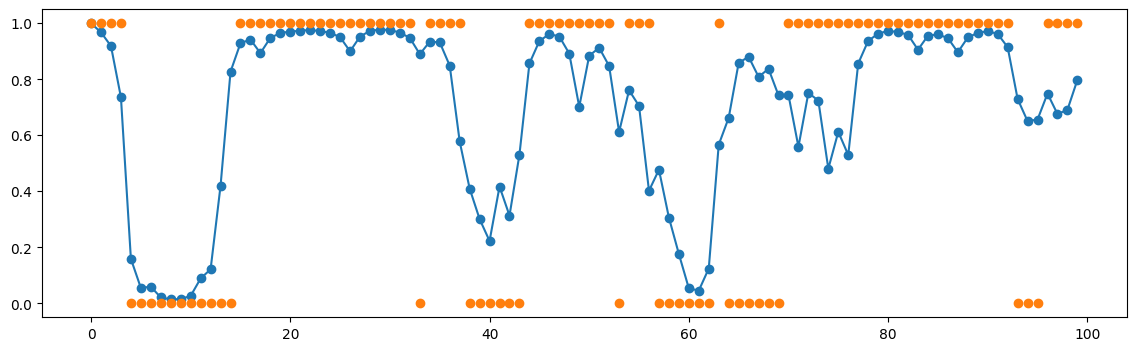

In [16]:
gamma, f, b = forwards_backwards(y, gamma0_true, T_mle, E_mle)
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o")

In [17]:
np.mean((gamma[:,1] > .5) == (x==1))

0.85

Now we get the correct state 85% of the time! (Remember with the true E and T we only got 86%!)

# Real data: single cell bisulphite sequencing

Now it's time to run on some real data. We'll be looking at the single cell Bisulphite sequencing ("scBS-seq") data from the DeepCpG paper.  

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import numpy as np

scBSseq = np.load("/content/drive/MyDrive/Assignment 3/scBSseq.npz") # might need to change this

meth_mat = scBSseq["meth_mat"] # positions x cells matrix of counts of methylated CpGs
unmeth_mat = scBSseq["unmeth_mat"] # positions x cells matrix of counts of unmethylated CpGs (i.e. C got converted to T)
positions = scBSseq["positions"] # genomic position of each CpG
chroms = scBSseq["chroms"] # chromomsome of each CpG
cell_names = scBSseq["cell_names"] # cell type and an arbitrary ID
cell_names

array(['2i_1', '2i_10', '2i_11', '2i_12', '2i_2', '2i_3', '2i_4', '2i_5',
       '2i_6', '2i_7', '2i_8', '2i_9', 'MII_1', 'MII_10', 'MII_11',
       'MII_12', 'MII_2', 'MII_3', 'MII_4', 'MII_5', 'MII_6', 'MII_7',
       'MII_8', 'MII_9', 'Ser1', 'Ser10', 'Ser11', 'Ser12', 'Ser13',
       'Ser14', 'Ser15', 'Ser16', 'Ser17', 'Ser18', 'Ser19', 'Ser2',
       'Ser20', 'Ser3', 'Ser4', 'Ser5', 'Ser6', 'Ser7', 'Ser8', 'Ser9'],
      dtype='<U6')

2i_N and SerN are (mouse) embryonic stem cells grown in either "2i" media or serum (from cows!). MII are oocytes which are used as "controls" here since they are easy to handle experimentally and have well defined blocks of methylation. The paper describing this data is [here](https://www-nature-com.ezproxy.cul.columbia.edu/articles/nmeth.3035) if you're interested in more of the technical details.

## Exploratory data analysis

It's always a good idea to do some exploratory data analysis (EDA) on a new dataset before trying out your fancy new ML model.

Especially in single-cell data it's important to get a sense how sparse the data is. We filtered this data for CpG positions with reads in at least 10 cells but the data is still pretty sparse:

0.2968330165185542

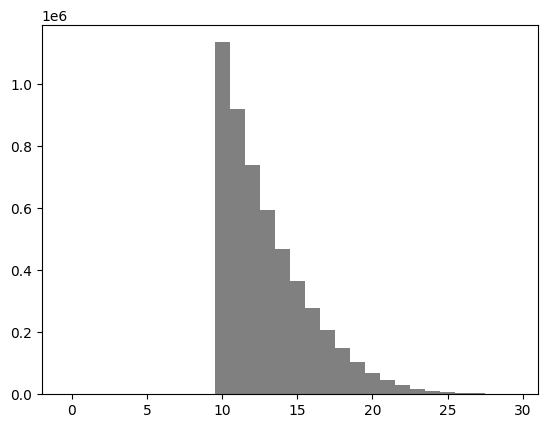

In [20]:
import matplotlib.pyplot as plt

total_counts = meth_mat + unmeth_mat
ncells_with_reads = (total_counts > 0).sum(1)
plt.hist(ncells_with_reads, np.arange(-.5,30.5) , color="gray")
np.mean(total_counts > 0)

So about 30% of entries have data.

Principal components analysis (PCA) is an excellent tool for EDA on high dimensional data. It's a little challenging to apply here because there's so much missingness: to handle that we'll add a small pseudocount and only look at CpGs where there is data for at least 25 cells (you can see from the histogram above this is a small proportion!)

Text(0.5, 0, 'PC')

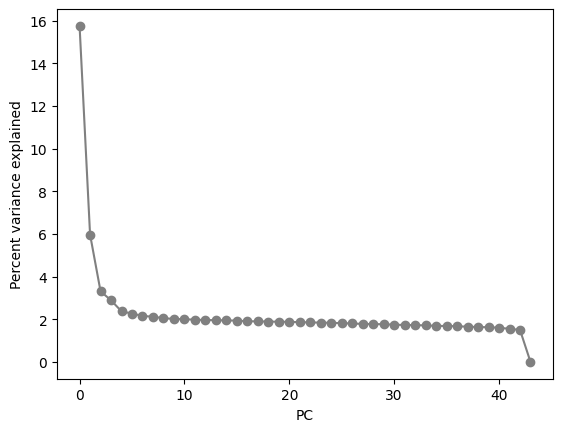

In [21]:
pseudocount = 0.25
meth_level = ( meth_mat + pseudocount) / (total_counts + 2 * pseudocount)
meth_level = meth_level[ncells_with_reads >= 25,:] # only consider CpG positions with reads in 25 (out of 44) cells

meth_level_centered = meth_level - meth_level.mean(1, keepdims=True) # remove the per position mean

# numpy implementation uses too much memory
# u,s,vh = np.linalg.svd(meth_level_centered, full_matrices=True) # use SVD to do PCA (quite cpu/memory intensive)
import torch
torch.manual_seed(0) # torch uses a randomized algorithm so set the seed for reproducibility

usvh = torch.pca_lowrank( torch.tensor(meth_level_centered).to("cuda"), q=44, center=False, niter=10)# 44 components
u,s,vh = [ g.cpu().numpy() for g in usvh ]
# u: # of left vectors representing the pc in the original space
# s: singular values (variance explained by each pc)
# vh: # of right vectors representing the pc in the original space
# right and left vectors come from the SVD (singular value decomposition) of the centered matrix

vh = vh.transpose()

plt.plot(100 * s**2 / np.sum(s**2), "o-", color="gray")
plt.ylabel("Percent variance explained")
plt.xlabel("PC")

In data analysis and PCA, the singular values in
Σ tell us the importance or the strength of each corresponding singular vector in capturing the variability in the data.

The left singular vectors (in U) are often used directly for dimensionality reduction, especially when dealing with tall matrices (more rows than columns).

The right singular vectors (in V) are used to understand the contribution of each original variable to the principal components.

The single values here tell us how much variance is represented by each PC. As is common with high dimensional data we see a lot of signal in the first few PCs.

Plotting the first two PCs we see that cell type drives much of the variation in the data - the cells separate by cell type for the most part. 2i and Ser samples look distinct but more similar to one another than to MII, which is expected given that they are the same cell type just grown in different conditions.

In [22]:
vh.shape

(44, 44)

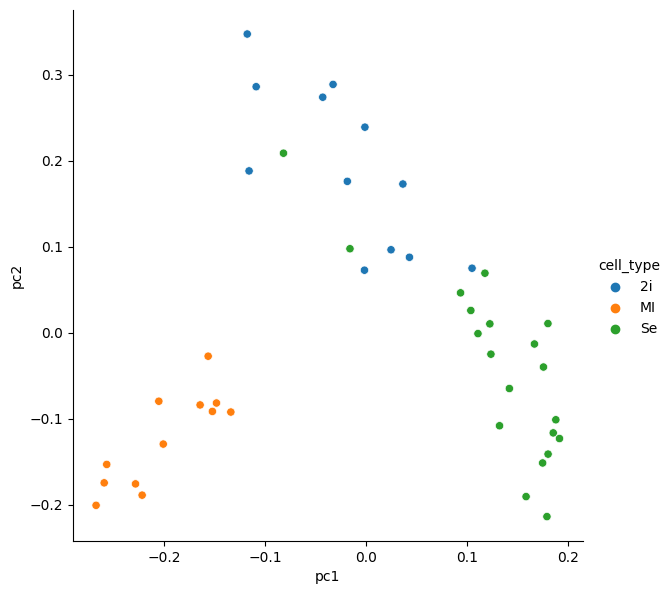

In [23]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(
    { "pc1" : vh[0,:],
      "pc2" : vh[1,:],
      "cell_type" : [ cn[:2] for cn in cell_names ] } )

_ = sns.pairplot(x_vars = ["pc1"], y_vars = ["pc2"], hue = "cell_type", data = df, height=6 )

## Applying the HMM

PCA isn't a great model for this data for two reasons:
1. It can't handle missingness (or count based likelihoods) naturally.
2. It ignores the sequential nature of the data.

So let's try using an HMM. The data at each CpG position is a vector of methylated and unmethylated counts, which it is natural to model using a binomial likelihood. The emission parameter $E_{ij} \in [0,1]$ is the probability of cell $j$ having a methylated CpG if the hidden state is $i$.

First we'll rewrite the forwards-backwards algorithm to be agnostic to the form of the likelihood.
(Previos Y was the sequence of observations. E was the emission)
### Task [2 point]

Write new forward backwards updates that take a matrix
This matrix represents the probability of observing $Y_t$
given that the hidden state at time $t$ is $k$.

$O_{kt} = P(Y_t | X_t = k) $ instead of Y and E. For the standard HMM
$O_{kt} = E_{kY_t}$.

We'll be using longer sequences where the standard implementation of the backwards update can end up being 0 to machine precision. To avoid this, wrap your b[t,:] calculation in a `norm` call (at every $t$ step, not just at the end!). We only care about the values of b[t,:] up to a multiplicative constant so this won't change anything.

Suppose you have an HMM with 3 states and you're calculating the forward probabilities for time step 3. The process would involve:

For each of the 3 states at time step 3, calculate how likely it is to be in that state based on:

The probabilities of being in each of the 3 states at time step 2.

The probabilities of transitioning from each of those states to the current state.

The probability of observing the current observation from the current state.

In [24]:
def forwards_generic(gamma0, T, O):
    '''
Forward pass of forwards-backwards algorithm.

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
  '''
    S = O.shape[1] # number of time steps in the sequence
    K = T.shape[0] # number of states
    f = np.zeros(shape=(S,K))
    f[0,:] = norm( O[:, 0] * gamma0 ) #before we had E[:,y[0]] * gamma0

    for t in range(1,S): #We need to iterate over the number of time steps in the sequence
        # For each time step t, we want to  consider the probability from the previous time step t-1 to update the probability at time t
        #For each state at time t, the algorithm calculates the probability of being in that state, considering all possible previous states.
        r_t = np.dot(f[t-1,:], T)
        f[t,:] = norm(O[:,t] * r_t) #before we had E[:,y[t]] * np.dot(f[t-1],T)
    return f


def backwards_generic(T, O):
    '''
Backwards pass of forwards-backwards algorithm.

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S
  '''
    S = O.shape[1]
    K = T.shape[0]
    # TODO
    b = np.zeros(shape=(S,K)) #S x K array filled with zeros
    b[S-1, :] = np.array([1] * K) # last row of b is all ones because there are no more observations after the last one, supposing that the sequence is complete summed to 1
# transpose?
    for t in range(S-2,-1,-1): #We need to iterate backwards over the number of time steps in the sequence
        q = O[:, t+1] * b[t+1, :]# intermediate vector q is the emission probability of the observation y[t+1] multiplied by the backward probability at time t+1 for each state
        b[t,:] = norm(T @ q) # updates the backward probabilities at time t for each state. It calculates the dot product of the transition matrix T and the intermediate vector q
    return b



def forwards_backwards_generic(gamma0, T, O):
    '''
Forwards-backwards algorithm.

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
gamma
    S x K matrix: posterior gamma[t,k] = P(X[t]=k | y[0:S])
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S
  '''
    f = forwards_generic(gamma0, T, O)
    b = backwards_generic(T, O)
    gamma = row_norm( f * b )
    return gamma, f, b

def forwards_backwards_check( y, gamma0, T, E ):
    O = E[:,y] # TODO: calculate O from E and y
    return forwards_backwards_generic(gamma0, T, O)

gamma, f, b = forwards_backwards( y, gamma0_true, T_true, E_true )
gamma_check, f, b = forwards_backwards_check( y, gamma0_true, T_true, E_true )
assert( abs(gamma[-1,1] - gamma_check[-1,1]) < 1e-10 )


Make sure the assertion passes.

## Binomial HMM

Now we're ready to make a version of forward-backwards for our binomial vectors. We want
$$ O_{kt} = P(Y_t | X_t = k) = \prod_{n=1}^N P(Y_{tn} | X_t = k) $$

The binomial likelihood for an individual cell is
$$ P(Y_{tn} | X_t = k) = Bin( M_{tn} | M_{tn} + U_{tn}, E_{k n} ) = E_{k n}^{M_{tn}} (1-E_{k n})^{U_{tn}} $$
where $M_{tn}$ and $U_{tn}$ are the methylated and unmethylated counts respectively and $E_{ij} = P(Y_{tj} = 1 | X_t = i )$ is a matrix of binomial probabilities. When multiplying probabilities together it's generally a good idea to work in log probability space, where multiplication corresponds to addition.

NOTE: a convenient aspect of the binomial likelihood is that $M_{tn} + U_{tn} = 0$ corresponds to entry $tn$ being missing, so we don't have to do anything special to handle "missingness".


### Task [1 point]

Write $\log O_{kt}$ in terms of $E$, $M$ and $U$:
$$\log O_{kt} = ? $$
$$
O_{kt} = P(Y_t | X_t = k) = \prod_{n=1}^N P(Y_{tn} | X_t = k)
$$

Each term $P(Y_{tn} | X_t = k)$ is a binomial probability, defined as:

$$
P(Y_{tn} | X_t = k) = E_{kn}^{M_{tn}} (1 - E_{kn})^{U_{tn}}
$$

Applying logarithm to the previous:

$$
\log(O_{kt}) = \log\left(\prod_{n=1}^N P(Y_{tn} | X_t = k)\right)
$$

$$
= \sum_{n=1}^N \log(P(Y_{tn} | X_t = k))
$$

Expanding the logarithm of the individual binomial probability:

$$
\log(P(Y_{tn} | X_t = k)) = \log\left(E_{kn}^{M_{tn}} (1 - E_{kn})^{U_{tn}}\right)
$$


$$
= \log(E_{kn}^{M_{tn}}) + \log((1 - E_{kn})^{U_{tn}})
$$

$$
= M_{tn} \log(E_{kn}) + U_{tn} \log(1 - E_{kn})
$$

FLAG: Check this
$$
\log(O_{kt}) = \sum_{n=1}^N(M_{tn} \log(E_{kn}) + U_{tn} \log(1 - E_{kn}))
$$




### Task [1 point]

Express this in matrix notation, where assuming the log function is applied elementwise:
$$\log O = ? $$

$$
\log(O) = (M\dot \log(E) + U\dot \log(1 - E))
$$




### Task [1 point]

Implement your calculation in this function. You should use the `np.log1p` in place of `np.log(1+.)` function where appropriate for better numerical stability!

In [25]:
def forwards_backwards_binomial( meth_mat, unmeth_mat, gamma0, T, E ):
    # TODO: calculate logO
    logO = np.log1p(-E) @ np.transpose(unmeth_mat) + np.log(E) @ np.transpose(meth_mat)
    logO -= logO.max(0,keepdims=True) # not strictly necessary but more numerically stable
    O = np.exp(logO)
    gamma, f, b = forwards_backwards_generic(gamma0, T, O)
    return gamma, f, b, O

It is often useful for methods with local optima (like EM fitting of an HMM) to use some fast and/or analytic method to get a reasonable initialization. As well as hopefully finding a better optimum than random initialization, this makes the analysis reproducible without setting random seeds.

One way to that here is using the PCA we've already done. The vh matrix is a PCs x L (cells) weight matrix analogous to the E matrix in our binomial model. We'll take the top K PCs of vh and rescale to get valid probabilities:

In [26]:
K = 10

E_init = vh[:K,:]
E_init -= E_init.min(1, keepdims=True)
E_init /= E_init.max(1, keepdims=True)
E_init = 0.8 * E_init + 0.1



For the transition matrix T we expect that the most likely transition is to stay in the same state (since we know neighboring CpGs have correlated methylation) so we'll just set T to have more weight on the diagonal:

In [27]:
T_init = row_norm(np.identity(K) + 1/K)

In [28]:
print(E_init.shape)
print(T_init.shape)
print(meth_mat[:30000,:].shape)
print(unmeth_mat[:30000,:].shape)

(10, 44)
(10, 10)
(30000, 44)
(30000, 44)


Now we can test our new forward-backwards algorithm on some of the "real" data. To keep things fast we'll just try this out on the first 30000 CpGs.


In [29]:
S = 30000 # np.sum(chroms=='1') # just run on chromosome 1

gamma0 = np.full(K,1/K)
gamma, f, b, O = forwards_backwards_binomial( meth_mat[:S,:], unmeth_mat[:S,:], gamma0, T_init, E_init )
print(abs(gamma[-1,4] - 1.0168727093165696e-06))
assert( abs(gamma[-1,4] - 1.0168727093165696e-06) < 1e-10 )

3.006966962752766e-19


In [30]:
gamma.shape

(30000, 10)

Make sure this assertion passes!

## Baum-Welch for the binomial HMM

Now let's implement Baum-Welch so we can find good parameters E and T for the binomial HMM applied to the methylation data.

### Task [2 points]

Derive the M-update for the emission matrix E. Students have struggled with this question in the past so I'm putting a lot more exposition here.

In the M step we try to optimize the expected log likelihood wrt whatever parameter (in this case E). So first you should figure out what the log likelihood is. The likelihood for an individual position and cell if we know $X_t=k$ is
$$P(Y_{tn} | X_t = k) = Bin( M_{tn} | M_{tn} + U_{tn}, E_{k n} ) = E_{k n}^{M_{tn}} (1-E_{k n})^{U_{tn}} $$
However, we don't know what state $X_t$ will be in so we can use the trick we used for the regular discrete likelihood HMM in class:
$$ P(Y_{tn} | X_t) = \prod_k P(Y_{tn} | X_t = k)^{1[X_t = k]}$$
where $1[.]$ is the indicator function and importantly $ \mathbb{E}_Q( 1[X_t = k]) = \gamma_{kt}$ where $\gamma$ comes from forward backwards.

The complete likelihood is just
$$ P(Y | X ) = \prod_{tn} P(Y_{tn} | X_t) $$

So you need to
- Take the log of $P(Y | X )$.
- substitute in the expression for $P(Y_{tn} | X_t)$
- substitute in the expression for $P(Y_{tn} | X_t = k)$
- take the expectation wrt $Q$ from forwards backwards (so you'll have $\gamma$ terms)
- maximize the resulting expression wrt to $ E_{kl} $. There are two ways to do this: 1) differentiate wrt to $ E_{kl} $, set that expression =0 and solve OR 2) look up the binomial likelihood (e.g. on wikipedia) and match to the function form you have, then you can get the optimal E just from looking up what the maximum likelihood estimator for the binomial is.

Finally you need to add the Beta(2,2) prior: you'll notice that the log pdf $ (2-1) \log E + (2-1) \log (1-E) $ has the same functional form as your final expression (this is due to beta being the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for the binomial) so it's easy to incorporate.

You should be able to do this using matrix multiplication rather than a loop. Include a pseudocount of 1 (corresponding to a Beta(2,2) prior on elements of E).

YOUR DERIVATION HERE
$$
E_{kn} = \frac{\sum_{t} \gamma_{kt} M_{tn}+1}{\sum_{t} \gamma_{kt} (M_{tn} + U_{tn}) + 2}
$$
FLAG : ADD SCANS OF CALCULATION

### Task [2 points]

Implement the M-update you just derived for the emission matrix in the code below:

In [31]:
def baum_welch_binomial(meth_mat, unmeth_mat, gamma0, E_init = None, T_init = None, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    meth_mat
        S x L matrix of methylated counts
    unmeth_mat
        S x L matrix of unmethylated counts
    gamma0
        initial distribution of the hidden chain
    E_init
        Optional initialization of emission matrix E.
    T_init
        Optional initialization of transition matrix T.
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j], the binomial probability of methylation in cell j, given X[t]=i.
  '''
    K = gamma0.size
    L = meth_mat.shape[1]
    S = meth_mat.shape[0]

    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) ) if (T_init is None) else T_init
    E = 0.1 + 0.8 * np.random.rand(K,L) if (E_init is None) else E_init # don't put values too close to 0 or 1

    it = 0

    param_change = np.inf

    while (param_change > tol) and (it<maxIt):
        it += 1
        print("Iteration: %i Param change: %.3g" % (it, param_change))
        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b, O = forwards_backwards_binomial(meth_mat, unmeth_mat, gamma0, T, E )
        assert(not np.any(np.isnan(gamma)))

        # M-step
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], O[:,t+1] * b[t+1,:] ) )
        T = row_norm(Tstar)

        # TODO: M-step update for E
        #E = np.dot(gamma.T, meth_mat) + 1 / (np.dot(gamma.T, meth_mat) + np.dot(gamma.T, unmeth_mat) + 2)
        E = (np.dot(gamma.T, meth_mat) + 1) / (np.dot(gamma.T, meth_mat + unmeth_mat) + 2)


        assert(not np.any(np.isnan(E)))

        #param_change = np.abs(oldT-T).sum() + np.abs(oldE-E).sum()
        param_change = max( np.abs(oldT-T).max() , np.abs(oldE-E).max() )

    return (T, E, gamma)

Alright, let's run it! We'll train on the first 30000 positions.

Because this is "real" data we can't check whether our estimates of T and E against against ground truth. One approach to assessing our model and parameters is prediction of held out data, just like we would for a supervised model. In this case we'll "hold out" the counts for entries with coverage > 1  (about 13% of entries) and if we can impute them.

In [32]:
test_meth = meth_mat[:S, :]
test_unmeth = unmeth_mat[:S, :]
test_total = test_meth + test_unmeth
to_mask = test_total >= 2 # often you would use a random set of entries
print(to_mask.mean()) # how many entries are we testing on?
test_meth_masked = test_meth.copy()
test_meth_masked[to_mask] = 0
test_unmeth_masked = test_unmeth.copy()
test_unmeth_masked[to_mask] = 0

T,E,gamma = baum_welch_binomial( test_meth_masked, test_unmeth_masked, gamma0, E_init = E_init, T_init = T_init, tol = 0.01 )

0.13284242424242423
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.763
Iteration: 3 Param change: 0.256
Iteration: 4 Param change: 0.177
Iteration: 5 Param change: 0.299
Iteration: 6 Param change: 0.184
Iteration: 7 Param change: 0.0812
Iteration: 8 Param change: 0.0568
Iteration: 9 Param change: 0.0465
Iteration: 10 Param change: 0.0543
Iteration: 11 Param change: 0.0539
Iteration: 12 Param change: 0.0459
Iteration: 13 Param change: 0.0348
Iteration: 14 Param change: 0.0246
Iteration: 15 Param change: 0.0198
Iteration: 16 Param change: 0.0223
Iteration: 17 Param change: 0.0253
Iteration: 18 Param change: 0.0289
Iteration: 19 Param change: 0.0334
Iteration: 20 Param change: 0.0377
Iteration: 21 Param change: 0.0392
Iteration: 22 Param change: 0.0364
Iteration: 23 Param change: 0.0314
Iteration: 24 Param change: 0.0266
Iteration: 25 Param change: 0.0217
Iteration: 26 Param change: 0.0177
Iteration: 27 Param change: 0.0149
Iteration: 28 Param change: 0.0141
Iteration: 29 Par

You'll notice that the parameters initially change quite a bit then convergence slows down. This is expected behavior for coordinate descent(/ascent), the class of methods that includes EM. For a graphical explanation
![coordinateascent](https://upload.wikimedia.org/wikipedia/commons/e/e3/Coordinate_descent.svg)

And bear in mind the issue is worse in higher dimensions. To cope with this we've set the tolerance pretty loose: in practice additional iterations beyond this often won't gain us anything in terms of predictive accuracy, and might even be detrimental if they result in overfitting (cf. early stopping).


Let's take a look at the learnt transition matrix T:

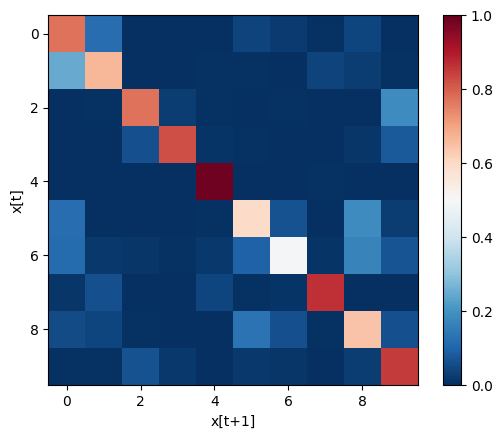

In [33]:
plt.imshow(T,vmin=0, vmax=1,cmap="RdBu_r")

plt.colorbar()
plt.ylabel("Hidden state")
plt.xlabel("x[t+1]")
_ = plt.ylabel("x[t]")

Mostly here the HMM stays in the same state, but various other transitions  have substantial mass too.

We can also look at the emission matrix, which shows clear patterns of states that correspond to methylation shared across cells of a specific type.

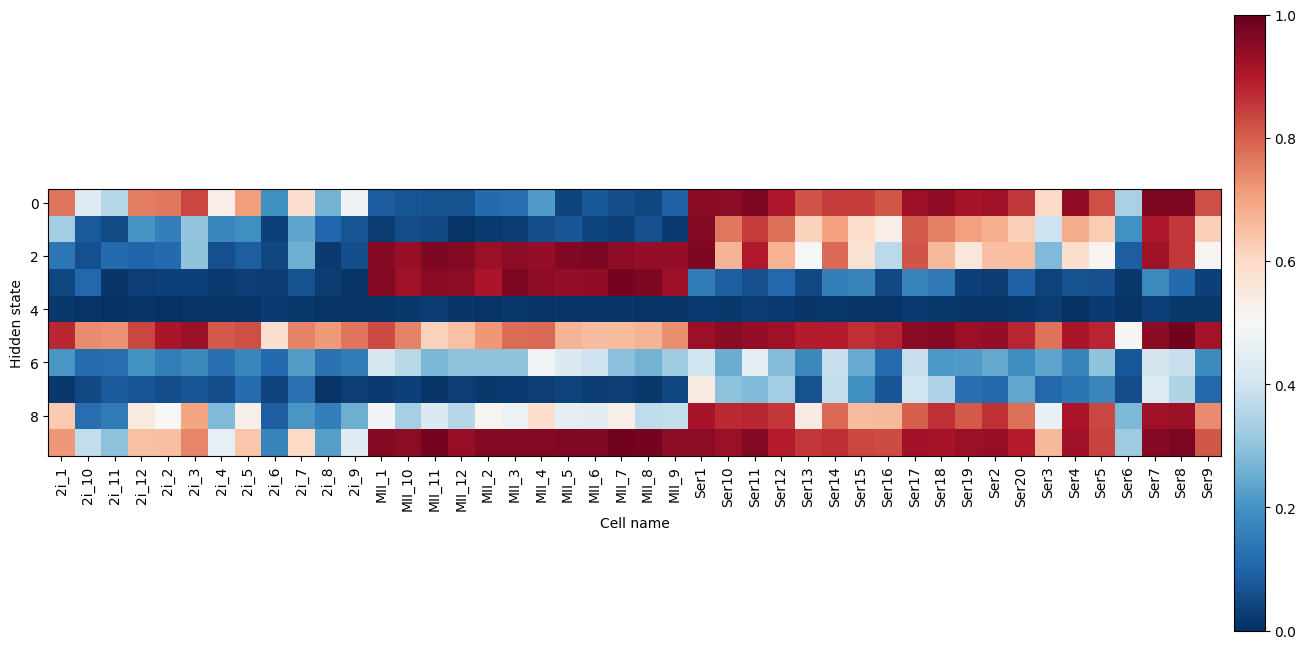

In [34]:
plt.figure(figsize=(18,8))
plt.imshow(E, vmin=0, vmax=1, cmap="RdBu_r")
_ = plt.xticks(np.arange(len(cell_names)), cell_names, rotation="vertical")
plt.colorbar(pad=0.009)
plt.xlabel("Cell name")
_ = plt.ylabel("Hidden state")

Now we want to calculate $ P(Y_\text{missing} | Y_\text{observed}, E, T) $. We will do this by summing over the posterior gamma_test.

### Task [1 point]

Derive $ Z_{tj} = P(Y^\text{missing}_{t} =j | Y_\text{observed}, E, T) $ in terms of $E_{ij} = P(Y_{tj} = 1 | X_t = i )$ and $ \gamma_{ti} = P( X_t = i | Y_\text{observed} )$ by using basic probability rules. You can do this with a single matrix multiply!

$$ Z_{tj} = \sum_i \gamma_{ti} E_{ij} $$
$$ Z = \gamma E $$

FLAG: ADD SCANS
### Task [1 point]

Implement your expression:

In [35]:
# TODO: calculate Z as the expected Y given the posterior over X. Should be S x L
Z = gamma @ E

Y_obs = test_meth / test_total
correct_pred = (Y_obs[to_mask]>.5) == (Z[to_mask]>.5)
correct_pred.mean()

<ipython-input-35-db2ba8ca99f6>:4: RuntimeWarning: invalid value encountered in divide
  Y_obs = test_meth / test_total


0.878427391760573

In [36]:
Z.shape

(30000, 44)

This should be 0.88, pretty good considering how sparse the data is.

Let's visualize some of our predictions:

<ipython-input-37-1cf45f8cbbf3>:10: RuntimeWarning: invalid value encountered in divide
  y = meth_mat[in_cpg,:] / ( unmeth_mat[in_cpg,:] + meth_mat[in_cpg,:] )


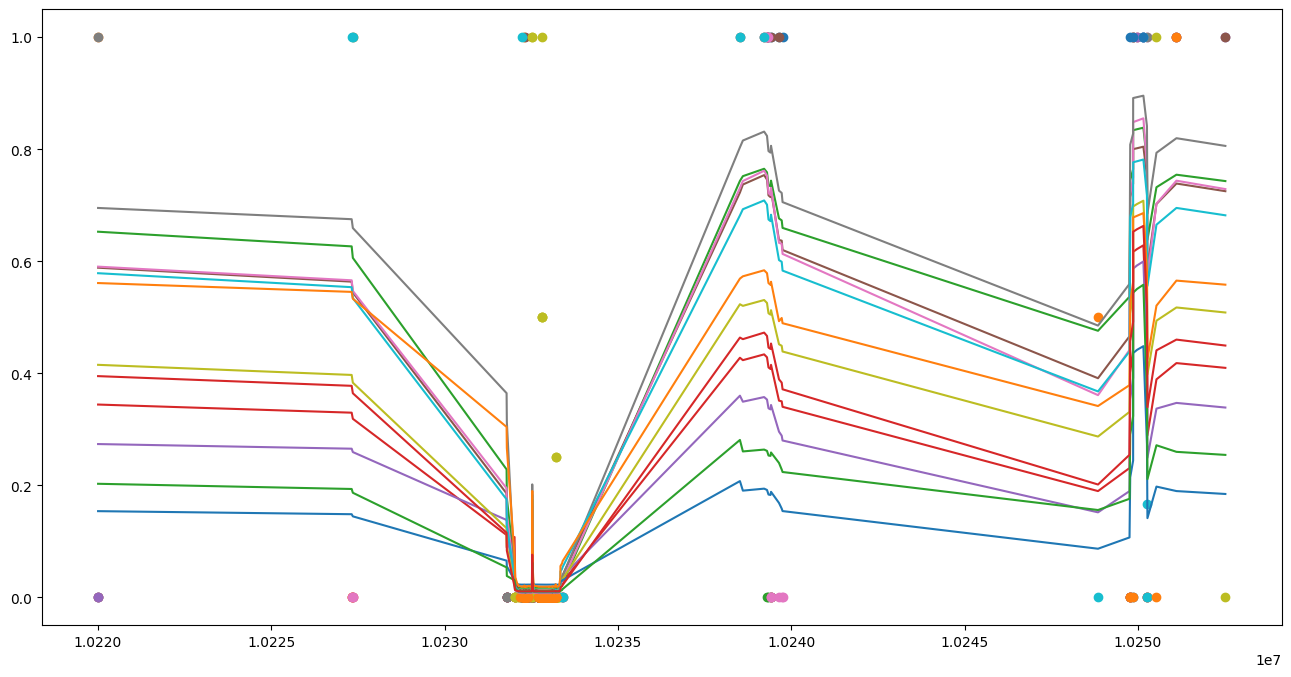

In [37]:
(cpg_start,cpg_end) = (10232143, 10233428)

window = 20000

in_cpg = np.logical_and( chroms == "1" , np.logical_and( cpg_start - window < positions , positions < cpg_end + window ))

meth_mat[in_cpg,:]
unmeth_mat[in_cpg,:]

y = meth_mat[in_cpg,:] / ( unmeth_mat[in_cpg,:] + meth_mat[in_cpg,:] )

plt.figure(figsize=(16,8))
_ = plt.plot( positions[in_cpg], y[:,:12], "o")
_ = plt.plot( positions[in_cpg], Z[in_cpg[:S],:12], "-")

The region with very low methylation is a CpG island. Think through how these lines are created: each position has a distribution over the possible states, and each state corresponds to a vector of binomial probabilities across the cells.



### Task [3 points]

Vary the number of hidden states from 1 to 10 and see how this impacts imputation accuracy and run time.

In [38]:
def initialize_vars(n_states):
  E_init = vh[:n_states,:]
  E_init -= E_init.min(1, keepdims=True)
  E_init /= E_init.max(1, keepdims=True)
  E_init = 0.8 * E_init + 0.1
  T_init = row_norm(np.identity(n_states) + 1/n_states)
  gamma0 = np.full(n_states,1/n_states)
  return E_init, T_init, gamma0

In [39]:
K_n = list(range(1, 11))
res = []
for k in K_n:
  print(f"{k} Hidden States")
  E_init, T_init, gamma0 = initialize_vars(k)
  T,E,gamma = baum_welch_binomial( test_meth_masked, test_unmeth_masked,
                                   gamma0, E_init = E_init, T_init = T_init, tol = 0.01 )
  Z = gamma @ E
  Y_obs = test_meth / test_total
  correct_pred = (Y_obs[to_mask]>.5) == (Z[to_mask]>.5)
  res.append((correct_pred.mean(), k))

1 Hidden States
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.375


<ipython-input-39-882311f8d19a>:9: RuntimeWarning: invalid value encountered in divide
  Y_obs = test_meth / test_total


2 Hidden States
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.802
Iteration: 3 Param change: 0.0875
Iteration: 4 Param change: 0.0205
3 Hidden States
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.822
Iteration: 3 Param change: 0.261
Iteration: 4 Param change: 0.119
Iteration: 5 Param change: 0.0815
Iteration: 6 Param change: 0.0328
Iteration: 7 Param change: 0.0137
4 Hidden States
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.729
Iteration: 3 Param change: 0.23
Iteration: 4 Param change: 0.125
Iteration: 5 Param change: 0.0734
Iteration: 6 Param change: 0.0531
Iteration: 7 Param change: 0.0345
Iteration: 8 Param change: 0.0242
Iteration: 9 Param change: 0.0195
Iteration: 10 Param change: 0.0177
Iteration: 11 Param change: 0.0171
Iteration: 12 Param change: 0.0165
Iteration: 13 Param change: 0.0159
Iteration: 14 Param change: 0.0157
Iteration: 15 Param change: 0.0156
Iteration: 16 Param change: 0.0154
Iteration: 17 Param change: 0.0156
Iteration

Text(0, 0.5, 'Accuracy')

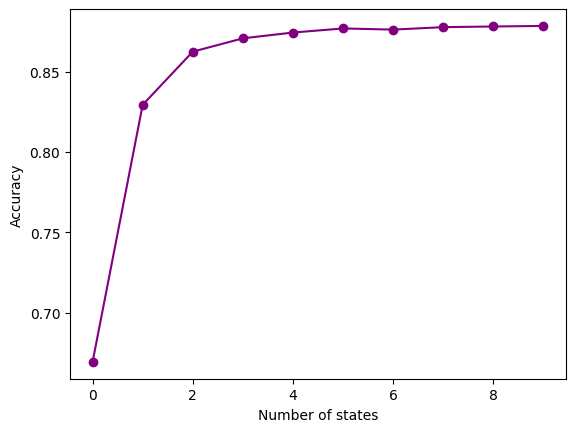

In [40]:
plt.plot([val[0] for val in res], color='purple', marker="o")
plt.xlabel("Number of states")
plt.ylabel("Accuracy")

# RNNs

In deep learning RNNs are often used to handle sequential data.

## Vanilla RNN

First we'll build a single vanilla "cell", an individual computation unit for the RNN.

In [41]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MyVanillaRNNCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(MyVanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, h_in):
        """
        Forward computation.

        Parameters
        ----------
        x : torch.tensor
            [batch_size x input_size] input
        h_in : torch.tensor
            [batch_size x hidden_size] hidden state from previous time point

        Returns
        -------
        h_out : torch.tensor
            [batch_size x hidden_size] new hidden state
        """
        combined = torch.cat((x, h_in), 1) # concatenate in feature dimension
        h_out = torch.tanh( self.linear(combined) ) #hyperbolic tangent of the elements
        return h_out



All this does is take the current input (x) and hidden state (h_in) and computes h_out according to $h_{out} = \tanh( W [x, h_in] + b )$. Although we don't see them explicitly in the code, the parameters $W$ and $b$ are stored in the `linear` layer.

Now we can build an RNN layer as

In [42]:
class MyRNNLayer(nn.Module):

    def __init__(self, rnn_cell):
        super(MyRNNLayer, self).__init__()
        self.rnn_cell = rnn_cell

    @property
    def hidden_size(self):
        return self.rnn_cell.hidden_size

    @property
    def input_size(self):
        return self.rnn_cell.input_size

    def forward(self, x):
        (seq_len, batch_size, input_size) = x.shape
        hidden = torch.zeros(batch_size, self.hidden_size, device = x.device) # could be an input to the function
        output = torch.zeros(seq_len, batch_size, self.hidden_size, device = x.device)
        for i in range(seq_len): # iterate over sequence
            hidden = self.rnn_cell(x[i,:,:], hidden)
            output[i,:,:] = hidden
        return output

Let's try running our RNN with random input:

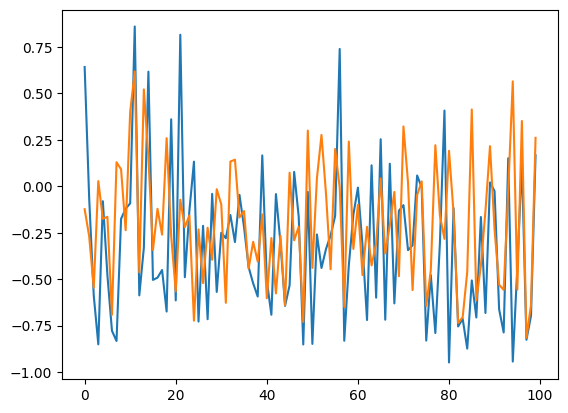

In [43]:
input_size = 4
hidden_size = 2
rnn_cell = MyVanillaRNNCell(input_size, hidden_size)
rnn = MyRNNLayer(rnn_cell)

x = torch.randn(100, 1, input_size) # random input length 100, batch_size = 1
hidden_state = rnn(x)

_ = plt.plot(hidden_state.detach().numpy().squeeze())

We expect the vanilla RNN won't be too useful because of vanishing gradients.

### Task [2 points]

Implement a slightly less vanilla RNN cell (still simpler than GRU or LSTM) where
$$ f_t = \sigma( W_f [ x_t , h_{t-1} ]^T + \mu_f ) $$
$$ g_t = \tanh( W_g [ x_t , h_{t-1} ]^T + \mu_g ) $$
$$ h_t = f_t \cdot h_{t-1} + (1 - f_t) \cdot g_t $$

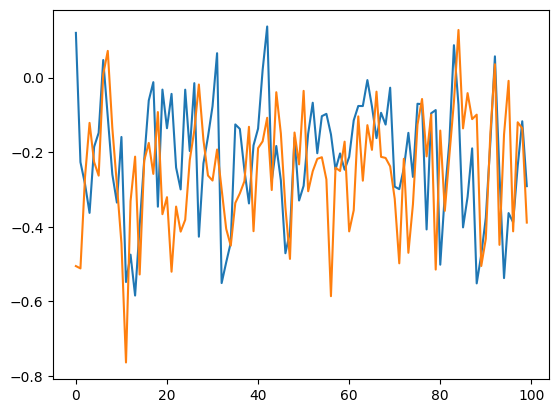

In [44]:
class MyLessVanillaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLessVanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear = nn.Linear(input_size + hidden_size, hidden_size)
        self.f_sigmoid = nn.Sigmoid()
        self.g_tanh = nn.Tanh()

    def forward(self, x, h_in):
        combined = torch.cat((x, h_in), 1) # concatenate in feature dimension
        f_t = self.f_sigmoid(self.linear(combined)) # sigmoid of the elements fed by the linear layer of concatenated x and h_in
        g_t = self.g_tanh(self.linear(combined)) # hyperbolic tangent of the elements fed by the linear layer of concatenated x and h_in
        h_t = f_t * h_in + (1 - f_t) * g_t #Final h_t is the element-wise multiplication of f_t and h_in plus the element-wise multiplication of 1-f_t and g_t
        return h_t


rnn_cell = MyLessVanillaRNNCell(input_size, hidden_size)
rnn = MyRNNLayer(rnn_cell)
output = rnn(x)
_ = plt.plot(output.detach().numpy().squeeze())

Run the above block a few times. Even with randomly initialized parameters you can often see there is somewhat longer term memory/behavior than you get with the vanilla RNN.

To make full regular RNN model we would also want to also calculate outputs as a function of the hidden states:

In [45]:
class BasicRNN(nn.Module):

    def __init__(self, rnn_layer, output_size):
        super(BasicRNN, self).__init__()
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(rnn_layer.hidden_size, output_size)

    def forward(self, x):
        h = self.rnn_layer(x)
        output = self.linear(h)
        return output

output_size = 3
rnn_cell = MyLessVanillaRNNCell(input_size, hidden_size)
rnn_layer = MyRNNLayer(rnn_cell)
model = BasicRNN(rnn_layer, output_size)
model(x).shape

torch.Size([100, 1, 3])

For our methylation data we'll initially consider each cell independently. The RNN input will be the methylated and unmethylated counts (two input features - channels if this were a CNN). Since we're considering cells as independent we can concentate the cells and batch dimensions using the pytorch `view` operator (analogous to `np.reshape`), apply the RNN layer, and then separate out the cells again using `view`.

In [46]:
class MethModel(nn.Module):
    def __init__(self, rnn_layer, input_size = 2, output_size = 1):
        super(MethModel, self).__init__()
        self.hidden_size = rnn_layer.hidden_size
        self.embed = nn.Linear(input_size, rnn_layer.input_size) # the embed layer runs independently on each pair of meth/unmeth counts
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(self.hidden_size, output_size) # the linear layer runs independently on each cell

    def forward(self, meth, unmeth): # meth is seq x batch x cells
        batch_size = meth.shape[1]
        num_cells = meth.shape[2]
        meth = meth.view(meth.shape[0], batch_size * num_cells)
        unmeth = unmeth.view(unmeth.shape[0], batch_size * num_cells)
        x = torch.stack((meth,unmeth),2) # seq x (cells x batch) x channels(=meth and unmeth counts)
        x = self.embed(x) # seq x cells(=batch) x channels
        x = F.relu(x)
        h = self.rnn_layer(x)
        if isinstance(self.rnn_layer, nn.RNNBase):
            h = h[0] # torch RNN layers give h[0:t] and h[-1]
        output = self.linear(h)
        output = output.view(output.shape[0], batch_size, num_cells, output.shape[-1])
        output = output[:,:,:,0]
        return output

In [47]:
class CpgDataset(torch.utils.data.Dataset):

    def __init__(self, meth_counts, unmeth_counts, seq_len = 1000):
        super(CpgDataset, self).__init__()
        self.meth_counts = meth_counts
        self.unmeth_counts = unmeth_counts
        self.seq_len = seq_len

    def __getitem__(self, i):
        return(self.meth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32),
               self.unmeth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32))

    def __len__(self):
        return self.meth_counts.shape[0] // self.seq_len

Our training loop should look very familiar from Assignment 1!



We want to do one step ahead prediction, i.e.
$ L = - \sum_{j=1}^J \sum_{t=1}^{T-1} \log Bin( M_{t+1,j} | M_{t+1,j} + U_{t+1,j}, p_{tj} ) $ where $p_{tj}$ is the output of the RNN at position $t$ and cell $j$. In practice it's usually better to take the mean rather than the sum over $J$ and $t$.

### Task [1 point]

Write out the loss explicitly with log function(s):  
$$ L =  - \sum_{j=1}^J \sum_{t=1}^{T-1} M_{t+1, j} \log p_{tj} + U_{t+1, j} \log (1 - p_{tj})$$

### Task [1 point]

Implement the binomial loss below

In [48]:
import timeit

def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval()

    losses = []
    accuracies = []

    for meth,unmeth in dataloader:

        # DataLoader's automatic batching makes batch x seq x cells tensors,
        # For RNNs we want seq x batch x cells
        meth = meth.transpose(0,1).contiguous()
        unmeth = unmeth.transpose(0,1).contiguous()

        (meth, unmeth) = ( meth.to(device), unmeth.to(device) ) # transfer data to GPU

        # forward
        logodds = model(meth, unmeth) # the output is seq x batch x cells

        lo = logodds[:-1,:,:] # shift by one since we're doing one-step (i.e. one CpG) ahead prediction
        prob_methylated = torch.sigmoid(lo)

        # TODO: calculate binomial loss
        #we need to slicce the tensors to take all elements from index 1 to end and all elements in the other dimensions
        loss = -torch.mean(meth[1:,:,:] * torch.log(prob_methylated) + unmeth[1:,:,:] * torch.log(1-prob_methylated))
        losses.append(loss.detach().cpu().numpy())

        if train_flag:
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        # calculate accuracy
        meth_sum = meth[1:,:,:] + unmeth[1:,:,:]
        meth_rate = meth[1:,:,:] / meth_sum
        correct = ((meth_rate > .5) == (prob_methylated > .5))[meth_sum > 0]
        accuracy = torch.mean( correct.float() )

        accuracies.append(accuracy.detach().cpu().numpy())

    return( np.mean(losses), np.mean(accuracies) )

def train_loop(model,
               optimizer,
               train_dataloader,
               validation_dataloader,
               check_point_filename = '/content/drive/MyDrive/Assignment 3/rnn_checkpoint.pt',
               max_epochs = 100,
               patience = 10,
               device = "cuda"):

    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf

    for epoch in range(max_epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" %
            (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else:
            patience_counter -= 1
            if patience_counter <= 0:
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break

    return(train_accs, val_accs)

In [49]:
batch_size = 100
seq_len = 1000

training_cpg = chroms == "18"
train_dataset = CpgDataset(meth_mat[training_cpg,:], unmeth_mat[training_cpg,:], seq_len = seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0 ) # actually slower with more workers

val_cpg = chroms == "19"
val_dataset = CpgDataset(meth_mat[val_cpg,:], unmeth_mat[val_cpg,:], seq_len = seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)

hidden_size = 32

rnn_cell = MyLessVanillaRNNCell(input_size = hidden_size, hidden_size = hidden_size)
rnn_layer = MyRNNLayer(rnn_cell)

model = MethModel(rnn_layer)

device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader,
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint.pt',
                                device = device,
                                max_epochs = 30)

test_cpg = chroms == "17"
test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)

test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

Epoch 1 took 21.82s. Train loss: 0.3868 acc: 0.3865. Val loss: 0.3971 acc: 0.4008. Patience left: 10
Epoch 2 took 20.81s. Train loss: 0.3755 acc: 0.4494. Val loss: 0.3844 acc: 0.5176. Patience left: 10
Epoch 3 took 20.79s. Train loss: 0.3651 acc: 0.5556. Val loss: 0.3726 acc: 0.6429. Patience left: 10
Epoch 4 took 20.75s. Train loss: 0.3553 acc: 0.7094. Val loss: 0.3613 acc: 0.8046. Patience left: 10
Epoch 5 took 20.70s. Train loss: 0.3461 acc: 0.7583. Val loss: 0.3506 acc: 0.7398. Patience left: 10
Epoch 6 took 20.72s. Train loss: 0.3374 acc: 0.6986. Val loss: 0.3403 acc: 0.7109. Patience left: 10
Epoch 7 took 20.90s. Train loss: 0.3292 acc: 0.6732. Val loss: 0.3307 acc: 0.6972. Patience left: 10
Epoch 8 took 20.70s. Train loss: 0.3217 acc: 0.6612. Val loss: 0.3219 acc: 0.6911. Patience left: 10
Epoch 9 took 20.70s. Train loss: 0.3151 acc: 0.6557. Val loss: 0.3140 acc: 0.6883. Patience left: 10
Epoch 10 took 20.74s. Train loss: 0.3093 acc: 0.6533. Val loss: 0.3072 acc: 0.6874. Patienc

Text(0, 0.5, 'Accuracy')

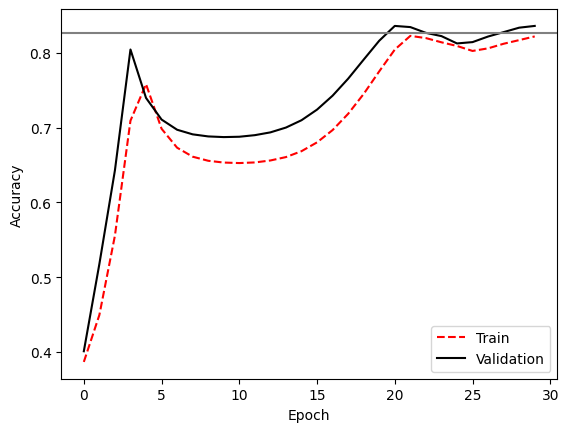

In [50]:
plt.plot(train_accs,  "--", label="Train",color='red')
plt.plot(val_accs, label="Validation",color='black')
plt.axhline(test_acc,color="gray")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## Task [5 points]

Compare the LessVanillaRNN, VanillaRNN, GRU and LSTM. For the latter 3 you can use the torch built in layers nn.RNN, nn.GRU and nn.LSTM since they run an order of magnitude faster (they have pure CUDA implementations). Note these built in modules implement the whole RNN layer, not just an individual cell. Stick to a max of 30 epochs. Run 3 random restarts (recreate the model instance so the parameters are randomly initialized) for each RNN to get a sense of how consistent the performance is. Plot the final train, validation and test accuracy. Discuss your results.



In [51]:
#Changed sizes to prevent CUDA errors and allocation of memory issues
batch_size = 50
seq_len = 500
device = "cuda"


training_cpg = chroms == "18"
train_dataset = CpgDataset(meth_mat[training_cpg,:], unmeth_mat[training_cpg,:], seq_len = seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0 )

val_cpg = chroms == "19"
val_dataset = CpgDataset(meth_mat[val_cpg,:], unmeth_mat[val_cpg,:], seq_len = seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)
test_cpg = chroms == "17"
test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)



In [52]:
def models(modelType, input_size, hidden_size, random_starts = 3):

    train, val, test = [], [], []

    for _ in range(random_starts):
      model = None

      if modelType == 'LessVanilla':
        rnn_cell = MyLessVanillaRNNCell(input_size = input_size, hidden_size = hidden_size)
        rnn_layer = MyRNNLayer(rnn_cell)
        model = MethModel(rnn_layer)

      elif modelType == 'Vanilla':
        rnn_layer = nn.RNN(input_size, hidden_size)
        model = MethModel(rnn_layer)

      elif modelType == 'GRU':
        rnn_layer = nn.GRU(input_size, hidden_size)
        model = MethModel(rnn_layer)

      elif modelType == 'LSTM':
        rnn_layer = nn.LSTM(input_size, hidden_size)
        model = MethModel(rnn_layer)

      else:
        raise Exception("Invalid model type")

      model.to(device)

      optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)
      train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader,
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint_models.pt',
                                device = device,
                                max_epochs = 30
                                )

      test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)

      train.append(train_accs)
      val.append(val_accs)
      test.append(test_acc)

    return np.array(train), np.array(val), np.array(test)

In [53]:
train_v, val_v, test_v = models('Vanilla', 32, 32)

Epoch 1 took 0.43s. Train loss: 0.3455 acc: 0.6882. Val loss: 0.3427 acc: 0.6927. Patience left: 10
Epoch 2 took 0.27s. Train loss: 0.3214 acc: 0.6657. Val loss: 0.3185 acc: 0.6916. Patience left: 10
Epoch 3 took 0.27s. Train loss: 0.3034 acc: 0.6673. Val loss: 0.2994 acc: 0.6955. Patience left: 10
Epoch 4 took 0.27s. Train loss: 0.2878 acc: 0.6818. Val loss: 0.2818 acc: 0.7193. Patience left: 10
Epoch 5 took 0.27s. Train loss: 0.2716 acc: 0.7119. Val loss: 0.2633 acc: 0.7556. Patience left: 10
Epoch 6 took 0.27s. Train loss: 0.2537 acc: 0.7630. Val loss: 0.2436 acc: 0.8063. Patience left: 10
Epoch 7 took 0.27s. Train loss: 0.2356 acc: 0.8021. Val loss: 0.2244 acc: 0.8213. Patience left: 10
Epoch 8 took 0.27s. Train loss: 0.2189 acc: 0.8098. Val loss: 0.2075 acc: 0.8335. Patience left: 10
Epoch 9 took 0.27s. Train loss: 0.2086 acc: 0.8205. Val loss: 0.2054 acc: 0.8335. Patience left: 10
Epoch 10 took 0.27s. Train loss: 0.2095 acc: 0.8165. Val loss: 0.2040 acc: 0.8359. Patience left: 10

In [54]:
train_g, val_g, test_g = models('GRU', 32, 32)

Epoch 1 took 0.54s. Train loss: 0.3836 acc: 0.5007. Val loss: 0.3724 acc: 0.6853. Patience left: 10
Epoch 2 took 0.53s. Train loss: 0.3431 acc: 0.6543. Val loss: 0.3363 acc: 0.6793. Patience left: 10
Epoch 3 took 0.53s. Train loss: 0.3194 acc: 0.6523. Val loss: 0.3149 acc: 0.6793. Patience left: 10
Epoch 4 took 0.52s. Train loss: 0.3038 acc: 0.6530. Val loss: 0.2992 acc: 0.6811. Patience left: 10
Epoch 5 took 0.52s. Train loss: 0.2900 acc: 0.6586. Val loss: 0.2845 acc: 0.6925. Patience left: 10
Epoch 6 took 0.52s. Train loss: 0.2759 acc: 0.6823. Val loss: 0.2699 acc: 0.7276. Patience left: 10
Epoch 7 took 0.52s. Train loss: 0.2620 acc: 0.7358. Val loss: 0.2557 acc: 0.7879. Patience left: 10
Epoch 8 took 0.52s. Train loss: 0.2488 acc: 0.7832. Val loss: 0.2416 acc: 0.8271. Patience left: 10
Epoch 9 took 0.52s. Train loss: 0.2363 acc: 0.8067. Val loss: 0.2283 acc: 0.8224. Patience left: 10
Epoch 10 took 0.53s. Train loss: 0.2249 acc: 0.8073. Val loss: 0.2169 acc: 0.8250. Patience left: 10

In [55]:
train_l, val_l, test_l = models('LSTM', 32, 32)

Epoch 1 took 0.46s. Train loss: 0.3711 acc: 0.6404. Val loss: 0.3794 acc: 0.6785. Patience left: 10
Epoch 2 took 0.46s. Train loss: 0.3543 acc: 0.6516. Val loss: 0.3589 acc: 0.6786. Patience left: 10
Epoch 3 took 0.47s. Train loss: 0.3377 acc: 0.6516. Val loss: 0.3380 acc: 0.6786. Patience left: 10
Epoch 4 took 0.46s. Train loss: 0.3209 acc: 0.6517. Val loss: 0.3172 acc: 0.6788. Patience left: 10
Epoch 5 took 0.47s. Train loss: 0.3044 acc: 0.6522. Val loss: 0.2974 acc: 0.6797. Patience left: 10
Epoch 6 took 0.47s. Train loss: 0.2880 acc: 0.6543. Val loss: 0.2782 acc: 0.6842. Patience left: 10
Epoch 7 took 0.46s. Train loss: 0.2708 acc: 0.6638. Val loss: 0.2599 acc: 0.7020. Patience left: 10
Epoch 8 took 0.47s. Train loss: 0.2549 acc: 0.6915. Val loss: 0.2451 acc: 0.7394. Patience left: 10
Epoch 9 took 0.47s. Train loss: 0.2431 acc: 0.7378. Val loss: 0.2360 acc: 0.7875. Patience left: 10
Epoch 10 took 0.46s. Train loss: 0.2354 acc: 0.7871. Val loss: 0.2286 acc: 0.8235. Patience left: 10

In [56]:
train_lv, val_lv, test_lv = models('LessVanilla', 32, 32)

Epoch 1 took 12.00s. Train loss: 0.3780 acc: 0.6126. Val loss: 0.3784 acc: 0.6786. Patience left: 10
Epoch 2 took 11.96s. Train loss: 0.3514 acc: 0.6516. Val loss: 0.3499 acc: 0.6786. Patience left: 10
Epoch 3 took 12.01s. Train loss: 0.3297 acc: 0.6516. Val loss: 0.3261 acc: 0.6786. Patience left: 10
Epoch 4 took 11.96s. Train loss: 0.3113 acc: 0.6522. Val loss: 0.3055 acc: 0.6807. Patience left: 10
Epoch 5 took 11.98s. Train loss: 0.2942 acc: 0.6587. Val loss: 0.2856 acc: 0.6963. Patience left: 10
Epoch 6 took 11.98s. Train loss: 0.2750 acc: 0.6880. Val loss: 0.2625 acc: 0.7494. Patience left: 10
Epoch 7 took 11.98s. Train loss: 0.2503 acc: 0.7697. Val loss: 0.2350 acc: 0.8364. Patience left: 10
Epoch 8 took 11.97s. Train loss: 0.2251 acc: 0.8122. Val loss: 0.2147 acc: 0.8186. Patience left: 10
Epoch 9 took 11.93s. Train loss: 0.2168 acc: 0.8050. Val loss: 0.2101 acc: 0.8236. Patience left: 10
Epoch 10 took 11.92s. Train loss: 0.2106 acc: 0.8132. Val loss: 0.2069 acc: 0.8350. Patienc

In [57]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Accuracy", "Validation Accuracy"))

trace_v = go.Scatter(y=np.mean(train_v, axis=0), mode='lines', name='Vanilla', line=dict(color="#F4E76E", width=3))
trace_lv = go.Scatter(y=np.mean(train_lv, axis=0), mode='lines', name='Less Vanilla', line=dict(color="#D7B377", width=3))
trace_g = go.Scatter(y=np.mean(train_g, axis=0), mode='lines', name='GRU', line=dict(color="#F42272", width=3))
trace_l = go.Scatter(y=np.mean(train_l, axis=0), mode='lines', name='LSTM', line=dict(color="#488286", width=3))


fig.add_trace(trace_v, row=1, col=1)
fig.add_trace(trace_lv, row=1, col=1)
fig.add_trace(trace_g, row=1, col=1)
fig.add_trace(trace_l, row=1, col=1)

trace_v_val = go.Scatter(y=np.mean(val_v, axis=0), mode='lines', name='Vanilla', showlegend=False, line=dict(color="#F4E76E", width=3))
trace_lv_val = go.Scatter(y=np.mean(val_lv, axis=0), mode='lines', name='Less Vanilla', showlegend=False, line=dict(color="#D7B377", width=3))
trace_g_val = go.Scatter(y=np.mean(val_g, axis=0), mode='lines', name='GRU', showlegend=False, line=dict(color="#F42272", width=3))
trace_l_val = go.Scatter(y=np.mean(val_l, axis=0), mode='lines', name='LSTM', showlegend=False, line=dict(color="#488286", width=3))


fig.add_trace(trace_v_val, row=1, col=2)
fig.add_trace(trace_lv_val, row=1, col=2)
fig.add_trace(trace_g_val, row=1, col=2)
fig.add_trace(trace_l_val, row=1, col=2)


fig.update_layout(
    xaxis=dict(
        title="Epoch",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    xaxis2=dict(
        title="Epoch",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    yaxis=dict(
        title="Accuracy",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    yaxis2=dict(
        title="Accuracy",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    plot_bgcolor='lightgray',

)

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.show()



In [58]:

trace_v = go.Scatter(x=['Vanilla'] * len(test_v), y=test_v, mode='markers', name='Vanilla', marker=dict(color="#F4E76E",size=15))
trace_lv  = go.Scatter(x=['Less Vanilla'] * len(test_lv ), y=test_lv , mode='markers', name='Less Vanilla', marker=dict(color="#D7B377",size=15))
trace_g  = go.Scatter(x=['GRU'] * len(test_g ), y=test_g , mode='markers', name='GRU', marker=dict(color="#F42272",size=14))
trace_l  = go.Scatter(x=['LSTM'] * len(test_l ), y=test_l , mode='markers', name='LSTM', marker=dict(color="#488286",size=14))

fig = go.Figure(data=[trace_v, trace_lv , trace_g , trace_l])

fig.update_layout(
    title="Model Accuracy",
    xaxis=dict(title="Model"),
    yaxis=dict(title="Accuracy", scaleanchor="x", scaleratio=1),
    autosize=False,
    width=700,
    height=700
)

fig.show()

Discussion

In our performed analysis, we examined four types of Recurrent Neural Networks (RNNs) - Vanilla RNN, Less Vanilla RNN, GRU (Gated Recurrent Unit), and LSTM (Long Short-Term Memory). These architectures are fundamental in processing sequential data and although they differ in their ability to capture dependencies in sequences.


The Vanilla RNN, being the most basic, struggled with our sequences due to the vanishing gradient problem, leading to the weakest performance in both training and validation accurracy. The Less Vanilla RNN, an iteration on the Vanilla RNN designed to mitigate some of these issues, did not show a marked improvement in our tests.

GRUs, which are better equipped to handle long sequences, demonstrated a slight but noticeable improvement in accuracy. However, their training and validation performance remained largely on par with the Vanilla and Less Vanilla RNNs.

Lastly, LSTMs, although known for their efficiency in managing long-term dependencies, it presented lower accurracy values compared to GRU. While the difference in performance was not drastic, we anticipate a more pronounced disparity in scenarios involving longer sequences that rely heavily on capturing long-term relationships.

## Sharing information across cells

Next we'll try to learn an RNN that shares information across cells like the HMM did and more like DeepCpG. Now our input is the methylated and unmethylated counts for all the cells. We first embed each cell's counts as before, and but then run the RNN on the concatenation of all the cells' embeddings (which we get using the view function).

In [59]:
class MethJointModel(nn.Module):
    def __init__(self, rnn_layer, input_size, num_cells, embedding_size):
        super(MethJointModel, self).__init__()
        self.embed = nn.Linear(input_size, embedding_size)
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(rnn_layer.hidden_size, num_cells)

    def forward(self, meth, unmeth):
        x = torch.stack((meth,unmeth),3) # seq x batch x cells x channels(=meth and unmeth counts)
        x = self.embed(x) # seq x batch x cells x hidden_size
        x = x.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]) # seq x batch x (cells x hidden_size)
        x = F.relu(x)
        h = self.rnn_layer(x)
        if isinstance(rnn_layer, nn.RNNBase): h = h[0] # torch RNN layers give h[0:t] and h[-1]
        output = self.linear(h)
        return output

In [60]:
hidden_size = 32
num_cells = meth_mat.shape[1]
embedding_size = 3

rnn_layer = nn.LSTM(input_size = num_cells * embedding_size, hidden_size = hidden_size)

model = MethJointModel(rnn_layer, input_size = 2, num_cells = num_cells, embedding_size = embedding_size)

device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader,
                                validation_dataloader,
                                check_point_filename = '/content/rnn_checkpoint_models.pt',
                                device = device,
                                max_epochs = 100) # high dimensional: takes longer to converge

test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

Epoch 1 took 0.13s. Train loss: 0.3767 acc: 0.5565. Val loss: 0.3909 acc: 0.6087. Patience left: 10
Epoch 2 took 0.13s. Train loss: 0.3639 acc: 0.6174. Val loss: 0.3758 acc: 0.6486. Patience left: 10
Epoch 3 took 0.13s. Train loss: 0.3508 acc: 0.6437. Val loss: 0.3604 acc: 0.6683. Patience left: 10
Epoch 4 took 0.12s. Train loss: 0.3383 acc: 0.6561. Val loss: 0.3466 acc: 0.6793. Patience left: 10
Epoch 5 took 0.12s. Train loss: 0.3267 acc: 0.6747. Val loss: 0.3347 acc: 0.7004. Patience left: 10
Epoch 6 took 0.12s. Train loss: 0.3165 acc: 0.6924. Val loss: 0.3231 acc: 0.7127. Patience left: 10
Epoch 7 took 0.13s. Train loss: 0.3064 acc: 0.7068. Val loss: 0.3123 acc: 0.7272. Patience left: 10
Epoch 8 took 0.12s. Train loss: 0.2972 acc: 0.7202. Val loss: 0.3029 acc: 0.7419. Patience left: 10
Epoch 9 took 0.13s. Train loss: 0.2886 acc: 0.7374. Val loss: 0.2935 acc: 0.7591. Patience left: 10
Epoch 10 took 0.12s. Train loss: 0.2801 acc: 0.7563. Val loss: 0.2835 acc: 0.7747. Patience left: 10

In [65]:

train_trace = go.Scatter(y=train_accs, mode='lines', name='train', line=dict( color="#A40E4C",width=3))
val_trace = go.Scatter(y=val_accs, mode='lines', name='validation',line=dict( color="#2C2C54",width=3))


test_trace = go.Scatter(x=[0, len(train_accs)-1], y=[test_acc, test_acc], mode='lines', name='test', line=dict(color='grey'))

fig = go.Figure(data=[train_trace, val_trace, test_trace])

fig.update_layout(
    title="Model Accuracy",
    xaxis=dict(title="Epoch"),
    yaxis=dict(title="Accuracy"),
    showlegend=True,
    width=700,
    height=700
)

fig.show()


## Task [3 points]

Vary ONE aspect of the RNN (most of these options are available through the torch RNN layers):
- number of RNN layers
- embedding size
- hidden size
- learning rate
- different optimizers (Adam, RMSprop, SGD with/without momentum)
- LSTM vs RNN vs GRU
- activation
- include varying levels of dropout

And compare performance. Again run 3 random restarts for each setting.

Plot and discuss your findings.

In [ ]:
#class MethJointModel(nn.Module):
#    def __init__(self, rnn_layer, input_size, num_cells, embedding_size):
#        super(MethJointModel, self).__init__()
#        self.embed = nn.Linear(input_size, embedding_size)
#        self.rnn_layer = rnn_layer
#        self.linear = nn.Linear(rnn_layer.hidden_size, num_cells)
#
#    def forward(self, meth, unmeth):
#        x = torch.stack((meth,unmeth),3) # seq x batch x cells x channels(=meth and unmeth counts)
#        x = self.embed(x) # seq x batch x cells x hidden_size
#        x = x.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]) # seq x batch x (cells x hidden_size)
#        x = F.relu(x)
#        h = self.rnn_layer(x)
#        if isinstance(rnn_layer, nn.RNNBase): h = h[0] # torch RNN layers give h[0:t] and h[-1]
#        output = self.linear(h)
#        return output

In [66]:
class MethJointModel_Layers(nn.Module):

    def __init__(self, rnn_layer_type, input_size, hidden_size, num_cells, embedding_size, num_layers):
        super(MethJointModel_Layers, self).__init__()
        self.embed = nn.Linear(input_size, embedding_size)

        if rnn_layer_type == 'LSTM':
            self.rnn_layer = nn.LSTM(num_cells*embedding_size, hidden_size, num_layers)
        elif rnn_layer_type == 'GRU':
            self.rnn_layer = nn.GRU(num_cells*embedding_size, hidden_size, num_layers)
        elif rnn_layer_type == 'RNN':
            self.rnn_layer = nn.RNN(num_cells*embedding_size, hidden_size, num_layers)
        else:
            raise ValueError("Invalid RNN layer type")

        self.linear = nn.Linear(hidden_size, num_cells)

    def forward(self, meth, unmeth):
        x = torch.stack((meth, unmeth), 3)
        x = self.embed(x)
        x = x.view(x.shape[0], x.shape[1], -1) #(cells x hidden_size) == -1 to calculate correct dimensions
        x = F.relu(x)

        output, _ = self.rnn_layer(x)
        output = self.linear(output)
        return output


In [71]:
def run_multilayer_models(hidden_size=32, embedding_size=3, random_starts=3):
    train, val, test = [], [], []
    num_cells = meth_mat.shape[1]

    for rnn_type in ['RNN', 'GRU', 'LSTM']:
        print(f"Network type: {rnn_type}")
        for num_layers in range(2, 11):
            print(f"Number of Layers: {num_layers}")
            for _ in range(random_starts):  # Loop for random restarts
                model = MethJointModel_Layers(rnn_type, input_size=2, hidden_size=hidden_size,
                                              num_cells=num_cells, embedding_size=embedding_size,
                                              num_layers=num_layers)

                device = "cuda"
                model.to(device)

                optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

                train_accs, val_accs = train_loop(model,
                                                  optimizer,
                                                  train_dataloader,
                                                  validation_dataloader,
                                                  check_point_filename='/content/rnn_checkpoint_models.pt',
                                                  device=device,
                                                  max_epochs=30)  # High dimensional: takes longer to converge

                test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)


                train.append((rnn_type, num_layers, train_accs))
                val.append((rnn_type, num_layers, val_accs))
                test.append((rnn_type, num_layers, test_acc))

    return np.array(train), np.array(val), np.array(test)


In [72]:
#Changed sizes to prevent CUDA errors and allocation of memory issues
batch_size = 50
seq_len = 500
device = "cuda"


training_cpg = chroms == "18"
train_dataset = CpgDataset(meth_mat[training_cpg,:], unmeth_mat[training_cpg,:], seq_len = seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0 )

val_cpg = chroms == "19"
val_dataset = CpgDataset(meth_mat[val_cpg,:], unmeth_mat[val_cpg,:], seq_len = seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)
test_cpg = chroms == "17"
test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)

train_comp, val_comp, test_comp = run_multilayer_models(hidden_size=32, embedding_size=3, random_starts=3)

Network type: RNN
Number of Layers: 2
Epoch 1 took 0.14s. Train loss: 0.3800 acc: 0.5123. Val loss: 0.3923 acc: 0.5686. Patience left: 10
Epoch 2 took 0.14s. Train loss: 0.3653 acc: 0.5781. Val loss: 0.3761 acc: 0.6221. Patience left: 10
Epoch 3 took 0.13s. Train loss: 0.3524 acc: 0.6223. Val loss: 0.3623 acc: 0.6631. Patience left: 10
Epoch 4 took 0.14s. Train loss: 0.3416 acc: 0.6494. Val loss: 0.3521 acc: 0.6651. Patience left: 10
Epoch 5 took 0.14s. Train loss: 0.3338 acc: 0.6643. Val loss: 0.3454 acc: 0.6794. Patience left: 10
Epoch 6 took 0.14s. Train loss: 0.3290 acc: 0.6658. Val loss: 0.3414 acc: 0.6803. Patience left: 10
Epoch 7 took 0.13s. Train loss: 0.3261 acc: 0.6703. Val loss: 0.3391 acc: 0.6830. Patience left: 10
Epoch 8 took 0.12s. Train loss: 0.3244 acc: 0.6713. Val loss: 0.3377 acc: 0.6831. Patience left: 10
Epoch 9 took 0.12s. Train loss: 0.3234 acc: 0.6712. Val loss: 0.3367 acc: 0.6831. Patience left: 10
Epoch 10 took 0.12s. Train loss: 0.3227 acc: 0.6710. Val loss:

<ipython-input-71-1e164720c222>:34: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [78]:
train_comp

array([['RNN', 2,
        list([0.5123331, 0.57812685, 0.6222979, 0.6494301, 0.6642669, 0.6658179, 0.670324, 0.67127085, 0.67121506, 0.6709741, 0.67008543, 0.6705427, 0.67450315, 0.67981035, 0.698167, 0.72895247, 0.7562682, 0.7738977, 0.78749305, 0.7963934, 0.80111194, 0.8043173, 0.8074716, 0.8110153, 0.81317204, 0.81469584, 0.81612664, 0.8180024, 0.81939965, 0.82041574])],
       ['RNN', 2,
        list([0.53401995, 0.5950044, 0.64098924, 0.6581822, 0.67459774, 0.6840162, 0.6944506, 0.7123916, 0.7422971, 0.7690826, 0.77382046, 0.7826274, 0.7952265, 0.8031096, 0.8094516, 0.8167119, 0.8214593, 0.8237198, 0.82589036, 0.8270796, 0.82823163, 0.8291504, 0.8298998, 0.8306566, 0.8313852, 0.83213276, 0.83292097, 0.83367014, 0.83441347, 0.8351498])],
       ['RNN', 2,
        list([0.5779421, 0.6341447, 0.6673563, 0.6688611, 0.6902953, 0.73803025, 0.7788999, 0.79200774, 0.8033018, 0.80832505, 0.81134266, 0.8168173, 0.8192911, 0.82197905, 0.8236744, 0.8246488, 0.8260579, 0.82699996, 0.82790095, 

In [86]:
lstm_train_comp = [entry for entry in train_comp if entry[0] == 'LSTM']

lstm_train_comp

[array(['LSTM', 2,
        list([0.54687816, 0.59686303, 0.6305166, 0.6494487, 0.6562851, 0.6659697, 0.6741925, 0.6880899, 0.7150653, 0.74077797, 0.7619877, 0.7776802, 0.79380447, 0.80167437, 0.8084938, 0.81289107, 0.8158701, 0.81847286, 0.82069904, 0.82228905, 0.82389754, 0.8255451, 0.8271978, 0.82884973, 0.830278, 0.83160377, 0.8329225, 0.83413047, 0.835196, 0.8362041])],
       dtype=object),
 array(['LSTM', 2,
        list([0.54139835, 0.55341256, 0.6276076, 0.655731, 0.6596117, 0.6652002, 0.6695347, 0.67104983, 0.671055, 0.671052, 0.67105037, 0.6710524, 0.67105395, 0.67105085, 0.671057, 0.67105705, 0.67105556, 0.67105246, 0.671052, 0.67105407, 0.6710551, 0.6710554, 0.6710556, 0.67105716, 0.6710562, 0.67105347, 0.6710525, 0.6710536, 0.67105293, 0.67105484])],
       dtype=object),
 array(['LSTM', 2,
        list([0.533318, 0.5859507, 0.63032037, 0.64350224, 0.6559786, 0.66887134, 0.66994286, 0.671066, 0.674767, 0.67296624, 0.67547894, 0.6820201, 0.6959164, 0.7106556, 0.7289319, 0.7

In [97]:

layer_colors = {
    2: '#CE1483',
    3: '#70B77E',
    4: '#129490',
    5: '#FF7700',
    6: '#A06B9A',
    7: '#F9DC5C',
    8: '#1098F7',
    9: '#801A86',
    10: '#C1DF1F'
}

fig = make_subplots(rows=1, cols=2, subplot_titles=("Individual Runs", "Average of Runs"))
max_epochs = 30

for num_layers in range(2, 11):
    lstm_accs = [accs for (m_type, layers, accs) in train_comp if m_type == 'LSTM' and layers == num_layers]
    if lstm_accs:
        lstm_accs_padded = [accs + [np.nan]*(max_epochs - len(accs)) if len(accs) < max_epochs else accs for accs in lstm_accs]

        for run_idx, accs in enumerate(lstm_accs_padded):
            epochs = list(range(1, max_epochs + 1))
            fig.add_trace(go.Scatter(x=epochs, y=accs, mode='lines', name=f'LSTM {num_layers} - Run {run_idx+1}', line=dict(color=layer_colors[num_layers])), row=1, col=1)

        avg_accs = np.nanmean(lstm_accs_padded, axis=0)
        fig.add_trace(go.Scatter(x=epochs, y=avg_accs, mode='lines+markers', name=f'LSTM {num_layers} - Average', line=dict(color=layer_colors[num_layers])), row=1, col=2)

fig.update_layout(title='LSTM Training Accuracies', xaxis_title='Epoch', yaxis_title='Accuracy', height=500, width=1000)
fig.show()


In [99]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Individual Runs", "Average of Runs"))
max_epochs = 30

for num_layers in range(2, 11):
    lstm_accs = [accs for (m_type, layers, accs) in val_comp if m_type == 'LSTM' and layers == num_layers]
    if lstm_accs:
        lstm_accs_padded = [accs + [np.nan]*(max_epochs - len(accs)) if len(accs) < max_epochs else accs for accs in lstm_accs]

        for run_idx, accs in enumerate(lstm_accs_padded):
            epochs = list(range(1, max_epochs + 1))
            fig.add_trace(go.Scatter(x=epochs, y=accs, mode='lines', name=f'LSTM {num_layers} - Run {run_idx+1}', line=dict(color=layer_colors[num_layers])), row=1, col=1)

        avg_accs = np.nanmean(lstm_accs_padded, axis=0)
        fig.add_trace(go.Scatter(x=epochs, y=avg_accs, mode='lines+markers', name=f'LSTM {num_layers} - Average', line=dict(color=layer_colors[num_layers])), row=1, col=2)

fig.update_layout(title='LSTM Validation Accuracies', xaxis_title='Epoch', yaxis_title='Accuracy', height=500, width=1000)
fig.show()


In [100]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("GRU Individual Runs", "GRU Average of Runs"))

for num_layers in range(2, 11):
    gru_accs = [accs for (m_type, layers, accs) in train_comp if m_type == 'GRU' and layers == num_layers]
    if gru_accs:
        gru_accs_padded = [accs + [np.nan]*(max_epochs - len(accs)) if len(accs) < max_epochs else accs for accs in gru_accs]

        for run_idx, accs in enumerate(gru_accs_padded):
            epochs = list(range(1, max_epochs + 1))
            fig.add_trace(go.Scatter(x=epochs, y=accs, mode='lines', name=f'GRU {num_layers} - Run {run_idx+1}', line=dict(color=layer_colors[num_layers])), row=1, col=1)

        avg_accs = np.nanmean(gru_accs_padded, axis=0)
        fig.add_trace(go.Scatter(x=epochs, y=avg_accs, mode='lines+markers', name=f'GRU {num_layers} - Average', line=dict(color=layer_colors[num_layers])), row=1, col=2)

fig.update_layout(title='GRU Training Accuracies', xaxis_title='Epoch', yaxis_title='Accuracy', height=500, width=1000)
fig.show()


In [101]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("GRU Individual Runs", "GRU Average of Runs"))

for num_layers in range(2, 11):
    gru_accs = [accs for (m_type, layers, accs) in val_comp if m_type == 'GRU' and layers == num_layers]
    if gru_accs:
        gru_accs_padded = [accs + [np.nan]*(max_epochs - len(accs)) if len(accs) < max_epochs else accs for accs in gru_accs]

        for run_idx, accs in enumerate(gru_accs_padded):
            epochs = list(range(1, max_epochs + 1))
            fig.add_trace(go.Scatter(x=epochs, y=accs, mode='lines', name=f'GRU {num_layers} - Run {run_idx+1}', line=dict(color=layer_colors[num_layers])), row=1, col=1)

        avg_accs = np.nanmean(gru_accs_padded, axis=0)
        fig.add_trace(go.Scatter(x=epochs, y=avg_accs, mode='lines+markers', name=f'GRU {num_layers} - Average', line=dict(color=layer_colors[num_layers])), row=1, col=2)

fig.update_layout(title='GRU Validation Accuracies', xaxis_title='Epoch', yaxis_title='Accuracy', height=500, width=1000)
fig.show()


In [102]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("RNN Individual Runs", "RNN Average of Runs"))

for num_layers in range(2, 11):
    rnn_accs = [accs for (m_type, layers, accs) in train_comp if m_type == 'RNN' and layers == num_layers]
    if rnn_accs:
        rnn_accs_padded = [accs + [np.nan]*(max_epochs - len(accs)) if len(accs) < max_epochs else accs for accs in rnn_accs]

        for run_idx, accs in enumerate(rnn_accs_padded):
            epochs = list(range(1, max_epochs + 1))
            fig.add_trace(go.Scatter(x=epochs, y=accs, mode='lines', name=f'RNN {num_layers} - Run {run_idx+1}', line=dict(color=layer_colors[num_layers])), row=1, col=1)

        avg_accs = np.nanmean(rnn_accs_padded, axis=0)
        fig.add_trace(go.Scatter(x=epochs, y=avg_accs, mode='lines+markers', name=f'RNN {num_layers} - Average', line=dict(color=layer_colors[num_layers])), row=1, col=2)

fig.update_layout(title='RNN Training Accuracies', xaxis_title='Epoch', yaxis_title='Accuracy', height=500, width=1000)
fig.show()


In [104]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("RNN Individual Runs", "RNN Average of Runs"))

for num_layers in range(2, 11):
    rnn_accs = [accs for (m_type, layers, accs) in val_comp if m_type == 'RNN' and layers == num_layers]
    if rnn_accs:
        rnn_accs_padded = [accs + [np.nan]*(max_epochs - len(accs)) if len(accs) < max_epochs else accs for accs in rnn_accs]

        for run_idx, accs in enumerate(rnn_accs_padded):
            epochs = list(range(1, max_epochs + 1))
            fig.add_trace(go.Scatter(x=epochs, y=accs, mode='lines', name=f'RNN {num_layers} - Run {run_idx+1}', line=dict(color=layer_colors[num_layers])), row=1, col=1)

        avg_accs = np.nanmean(rnn_accs_padded, axis=0)
        fig.add_trace(go.Scatter(x=epochs, y=avg_accs, mode='lines+markers', name=f'RNN {num_layers} - Average', line=dict(color=layer_colors[num_layers])), row=1, col=2)

fig.update_layout(title='RNN Validation Accuracies', xaxis_title='Epoch', yaxis_title='Accuracy', height=500, width=1000)
fig.show()


Discussion

In our analysis, we explored the performance of three variants of Recurrent Neural Networks (RNNs) - the standard RNN, GRU (Gated Recurrent Unit), and LSTM (Long Short-Term Memory) - by varying the number of layers from 2 to 10.

Upon initial examination, we found that the performance trends were remarkably consistent across these network types. A notable observation was that all configurations experienced difficulties with 8, 9, and 10 layers, consistenly in all three of our random tests. This issue might come from a potential overfitting in the system due to an excess of layers.

Conversely, the optimal performance for all models was observed when using either 2 or 3 layers, suggesting a more efficient and streamlined network structure at these levels.


Additionally, our testing accuracies (plots can be found under this discussion), confirmed our earlier observations. Strikingly, the LSTM networks consistently underperformed compared to the other two types of networks, regardless of the number of layers. However, it's important to note that LSTMs are particularly designed to handle longer sequences, capturing long-term relationships more effectively. Given this characteristic, it would be worthwhile to further explore scenarios where longer sequences are involved and analyze the performance of LSTM networks in such contexts.




In [116]:

test_comp = [[entry[0], int(entry[1]), float(entry[2])] for entry in test_comp]

mean_accuracies = {}
for rnn_type in set(entry[0] for entry in test_comp):
    for num_layers in set(entry[1] for entry in test_comp if entry[0] == rnn_type):
        accuracies = [entry[2] for entry in test_comp if entry[0] == rnn_type and entry[1] == num_layers]
        mean_accuracies[(rnn_type, num_layers)] = np.mean(accuracies)

rnn_types = sorted(set(entry[0] for entry in test_comp))
layer_counts = sorted(set(entry[1] for entry in test_comp))

fig = go.Figure()

for rnn_type in rnn_types:
    mean_acc_by_layer = [mean_accuracies[(rnn_type, num_layers)] for num_layers in layer_counts]
    fig.add_trace(go.Scatter(
        x=layer_counts,
        y=mean_acc_by_layer,
        mode='lines+markers',
        name=rnn_type
    ))
fig.update_layout(
    title='Test Accuracies by RNN Type and Number of Layers',
    xaxis_title='Number of Layers',
    yaxis_title='Mean Test Accuracy',
    xaxis=dict(tickmode='array', tickvals=layer_counts),
    height=700,
    width=700
)

fig.show()

In [113]:

fig = go.Figure()

for rnn_type in ['RNN', 'GRU', 'LSTM']:
    for num_layers in range(2, 11):

        test_accs = [acc for (m_type, layers, acc) in test_comp if m_type == rnn_type and layers == num_layers]
        if test_accs:
            mean_test_acc = np.mean(test_accs)

            fig.add_trace(go.Scatter(
                x=[f'{rnn_type} {num_layers}'],
                y=[mean_test_acc],
                mode='markers',
                name=f'{rnn_type} {num_layers}'
            ))


fig.update_layout(title='Test Accuracies Across RNN Types and Layer Configurations',
                  xaxis_title='RNN Type and Number of Layers',
                  yaxis_title='Mean Test Accuracy',
                  showlegend=False)
fig.show()


## Task [2 points, extra credit]

- Test set accuracy over 90%: 1 point
- Test set accuracy over 95%: 1 more point

In [237]:
class MethJointModel_Extra(nn.Module):
    def __init__(self, rnn_layer, input_size, hidden_size, num_cells, embedding_size):
        super(MethJointModel_Extra, self).__init__()
        self.embed = nn.Linear(input_size, embedding_size)
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(hidden_size * 2, num_cells)

    def forward(self, meth, unmeth):
        x = torch.stack((meth,unmeth),3)
        x = self.embed(x)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = F.relu(x)
        h = x
        for layer in self.rnn_layer:
          h, _ = layer(h)
        output = self.linear(h)
        return output

In [240]:
embedding_size = 64
num_cells = meth_mat.shape[1]


rnn_layers = nn.ModuleList([nn.LSTM(input_size = num_cells * embedding_size,
                                    hidden_size = 64,
                                    num_layers=3,
                                    bidirectional=True)])

model = MethJointModel_Extra(rnn_layers,
                             input_size = 2,
                             hidden_size=hidden_size,
                             num_cells = num_cells,
                             embedding_size = embedding_size)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)


batch_size = 10
seq_len = 500
device = "cuda"
model.to(device)

training_cpg = chroms == "18"
train_dataset = CpgDataset(meth_mat[training_cpg,:], unmeth_mat[training_cpg,:], seq_len = seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0 )

val_cpg = chroms == "19"
val_dataset = CpgDataset(meth_mat[val_cpg,:], unmeth_mat[val_cpg,:], seq_len = seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)
test_cpg = chroms == "17"
test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = batch_size,
                                               num_workers = 0)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader,
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint_extra.pt',
                                device = device,
                                max_epochs = 100
                                )

Epoch 1 took 1.00s. Train loss: 0.2962 acc: 0.7329. Val loss: 0.2130 acc: 0.8414. Patience left: 10
Epoch 2 took 0.91s. Train loss: 0.1912 acc: 0.8401. Val loss: 0.1793 acc: 0.8605. Patience left: 10
Epoch 3 took 1.00s. Train loss: 0.1713 acc: 0.8555. Val loss: 0.1656 acc: 0.8709. Patience left: 10
Epoch 4 took 0.91s. Train loss: 0.1591 acc: 0.8657. Val loss: 0.1542 acc: 0.8796. Patience left: 10
Epoch 5 took 0.90s. Train loss: 0.1493 acc: 0.8745. Val loss: 0.1460 acc: 0.8865. Patience left: 10
Epoch 6 took 0.90s. Train loss: 0.1407 acc: 0.8822. Val loss: 0.1372 acc: 0.8941. Patience left: 10
Epoch 7 took 0.91s. Train loss: 0.1317 acc: 0.8906. Val loss: 0.1310 acc: 0.8985. Patience left: 10
Epoch 8 took 0.92s. Train loss: 0.1260 acc: 0.8947. Val loss: 0.1266 acc: 0.9008. Patience left: 10
Epoch 9 took 0.92s. Train loss: 0.1217 acc: 0.8970. Val loss: 0.1228 acc: 0.9027. Patience left: 10
Epoch 10 took 0.91s. Train loss: 0.1180 acc: 0.8990. Val loss: 0.1194 acc: 0.9042. Patience left: 10

In [261]:

train_accs_sliced = train_accs[:80]
val_accs_sliced = val_accs[:80]

fig = go.Figure()
fig.add_trace(go.Scatter(y=train_accs_sliced, mode='lines', name='Training',line=dict(color="#D6F49D", width=3)))
fig.add_trace(go.Scatter(y=val_accs_sliced, mode='lines', name='Validation',line=dict(color="#06BCC1", width=3)))

fig.update_layout(
    title="Training and Validation Accuracy",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    legend_title="Legend",
    width=700,
    height=700
)
fig.update_layout(
    xaxis=dict(
        title="Epoch",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    xaxis2=dict(
        title="Epoch",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    yaxis=dict(
        title="Accuracy",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    yaxis2=dict(
        title="Accuracy",
        gridcolor='white',
        gridwidth=2,
        linecolor='white',
        linewidth=3,
        mirror=True
    ),
    plot_bgcolor='#D5D5D5',

)

# Show the figure
fig.show()


ValueError: ignored